# Input Driven Observations ("GLM-HMM")

Notebook prepared by Zoe Ashwood: feel free to email me with feedback or questions (zashwood at cs dot princeton dot edu).

This notebook demonstrates the "InputDrivenObservations" class, and illustrates its use in the context of modeling decision-making data as in Ashwood et al. (2020) ([Mice alternate between discrete strategies during perceptual
decision-making](https://www.biorxiv.org/content/10.1101/2020.10.19.346353v1.full.pdf)).

Compared to the model considered in the notebook ["2 Input Driven HMM"](https://github.com/lindermanlab/ssm/blob/master/notebooks/2%20Input%20Driven%20HMM.ipynb), Ashwood et al. (2020) assumes a stationary transition matrix where transition probabilities *do not* depend on external inputs. However, observation probabilities now *do* depend on external covariates according to:


for $c \neq C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

and for $c = C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{1}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

where $c \in \{1, ..., C\}$ indicates the categorical class for the observation, $u_{t} \in \mathbb{R}^{M}$ is the set of input covariates, and $w_{kc} \in \mathbb{R}^{M}$ is the set of input weights associated with state $k$ and class $c$. These weights, along with the transition matrix and initial state probabilities, will be learned.

In Ashwood et al. (2020), $C = 2$ as $y_{t}$ represents the binary choice made by an animal during a 2AFC (2-Alternative Forced Choice) task. The above equations then reduce to:

$$
\begin{align}
\Pr(y_t = 0 \mid z_{t} = k, u_t, w_{k}) = 
\frac{\exp\{w_{k}^\mathsf{T} u_t\}}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}} = \frac{1}
{1 + \exp\{-w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

$$
\begin{align}
\Pr(y_t = 1 \mid z_{t} = k, u_t, w_{k}) = 
\frac{1}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

and only a single weight vector, $w_{k}$, is associated with each state.

## 1. Setup
The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [1]:
import numpy as np
import pandas as pd

import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation

npr.seed(0)

In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.utils.capture import capture_output
import os, sys
import numpy as np
import pandas as pd
from importlib import reload

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from tableone import TableOne

In [4]:
### rpy2
import sys
sys.executable
import rpy2
print(rpy2.__version__)
import os
os.environ['PATH'] = r'C:\Program Files\R\R-4.2.1\bin\x64'
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.2.1' #path to your R installation
os.environ['R_USER'] = r'C:\Users\aynaz.adlzarrabi\Anaconda3\Lib\site-packages\rpy2' #path depends on where you installed Python. Mine is the Anaconda distribution
os.environ['R_LIBS_USER'] = r'C:\Program Files\R\R-4.2.1\library'
import rpy2.situation
for row in rpy2.situation.iter_info():
    print(row)
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
base = importr('base')
utils = importr('utils')
#%load_ext rpy2.ipython

3.5.6
rpy2 version:
3.5.6
Python version:
3.8.3 (tags/v3.8.3:6f8c832, May 13 2020, 22:37:02) [MSC v.1924 64 bit (AMD64)]
Looking for R's HOME:
    Environment variable R_HOME: C:\Program Files\R\R-4.2.1
    InstallPath in the registry: C:\Program Files\R\R-4.3.2
    Environment variable R_USER: C:\Users\aynaz.adlzarrabi\Anaconda3\Lib\site-packages\rpy2
    Environment variable R_LIBS_USER: C:\Program Files\R\R-4.2.1\library
R version:
    In the PATH: R version 4.2.1 (2022-06-23 ucrt) -- "Funny-Looking Kid"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:


In [5]:
import pingouin as pg
from scipy.stats import mannwhitneyu, probplot, shapiro,chi2_contingency, kruskal
from pymer4.models import Lm
from statsmodels.formula.api import ols
from statsmodels.stats import multicomp as mc
from statsmodels.stats.diagnostic import normal_ad, het_breuschpagan, acorr_ljungbox,kstest_fit

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
sys.path.insert(0, os.path.abspath('../../2022/palin/python'))
import palin as pa
from palin.utils import utils
from palin.internal_noise import optimize
from palin.internal_noise import grid
from palin.kernels import classification_images

In [7]:
reload(pa)
reload(grid)
reload(utils)
reload(optimize)
reload(classification_images)

<module 'palin.kernels.classification_images' from 'g:\\Utilisateurs\\aynaz.adlzarrabi\\Documents\\WORK\\DO\\2022\\palin\\python\\palin\\kernels\\classification_images.py'>

The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

## 1.load data

In [8]:
revcor_data=pd.read_csv('data/revcor_data.csv', index_col=0, parse_dates=['date'])
revcor_data

old_subject  trial  block  sex   age                       date  \
0                12      0      0    m  70.0 2019-12-02 15:26:04.752128   
1                12      0      0    m  70.0 2019-12-02 15:26:04.752128   
2                12      0      0    m  70.0 2019-12-02 15:26:04.752128   
3                12      0      0    m  70.0 2019-12-02 15:26:04.752128   
4                12      0      0    m  70.0 2019-12-02 15:26:04.752128   
...             ...    ...    ...  ...   ...                        ...   
174841            5    600      6  NaN   NaN 2016-05-23 00:00:00.000000   
174842            5    600      6  NaN   NaN 2016-05-23 00:00:00.000000   
174843            5    600      6  NaN   NaN 2016-05-23 00:00:00.000000   
174844            5    600      6  NaN   NaN 2016-05-23 00:00:00.000000   
174845            5    600      6  NaN   NaN 2016-05-23 00:00:00.000000   

                              stim  stim_order  segment  segment_time  \
0       male_vraiment_flat_141.wav           0        0      0.000000   
1       male_vraiment_flat_141.wav           0        1      0.071043   
2       male_vraiment_flat_141.wav           0        2      0.142086   
3       male_vraiment_flat_141.wav           0        3      0.213129   
4       male_vraiment_flat_141.wav           0        4      0.284172   
...                            ...         ...      ...           ...   
174841         Sub5_Trial595_1.wav           1        2      2.000000   
174842         Sub5_Trial595_1.wav           1        3      3.000000   
174843         Sub5_Trial595_1.wav           1        4      4.000000   
174844         Sub5_Trial595_1.wav           1        5      5.000000   
174845         Sub5_Trial595_1.wav           1        6      6.000000   

             pitch  response      rt      type experimentor  session  subject  
0         7.977104      True  12.930  patients       bardet        1       16  
1        82.432249      True  12.930  patients       bardet        1       16  
2       132.317275      True  12.930  patients       bardet        1       16  
3       -14.753525      True  12.930  patients       bardet        1       16  
4       -26.994032      True  12.930  patients       bardet        1       16  
...            ...       ...     ...       ...          ...      ...      ...  
174841   13.496392     False   1.622  controls       ponsot        1       11  
174842  -30.745334     False   1.622  controls       ponsot        1       11  
174843  -13.769432     False   1.622  controls       ponsot        1       11  
174844   -0.266028     False   1.622  controls       ponsot        1       11  
174845  -13.508295     False   1.622  controls       ponsot        1       11  

[174846 rows x 17 columns]

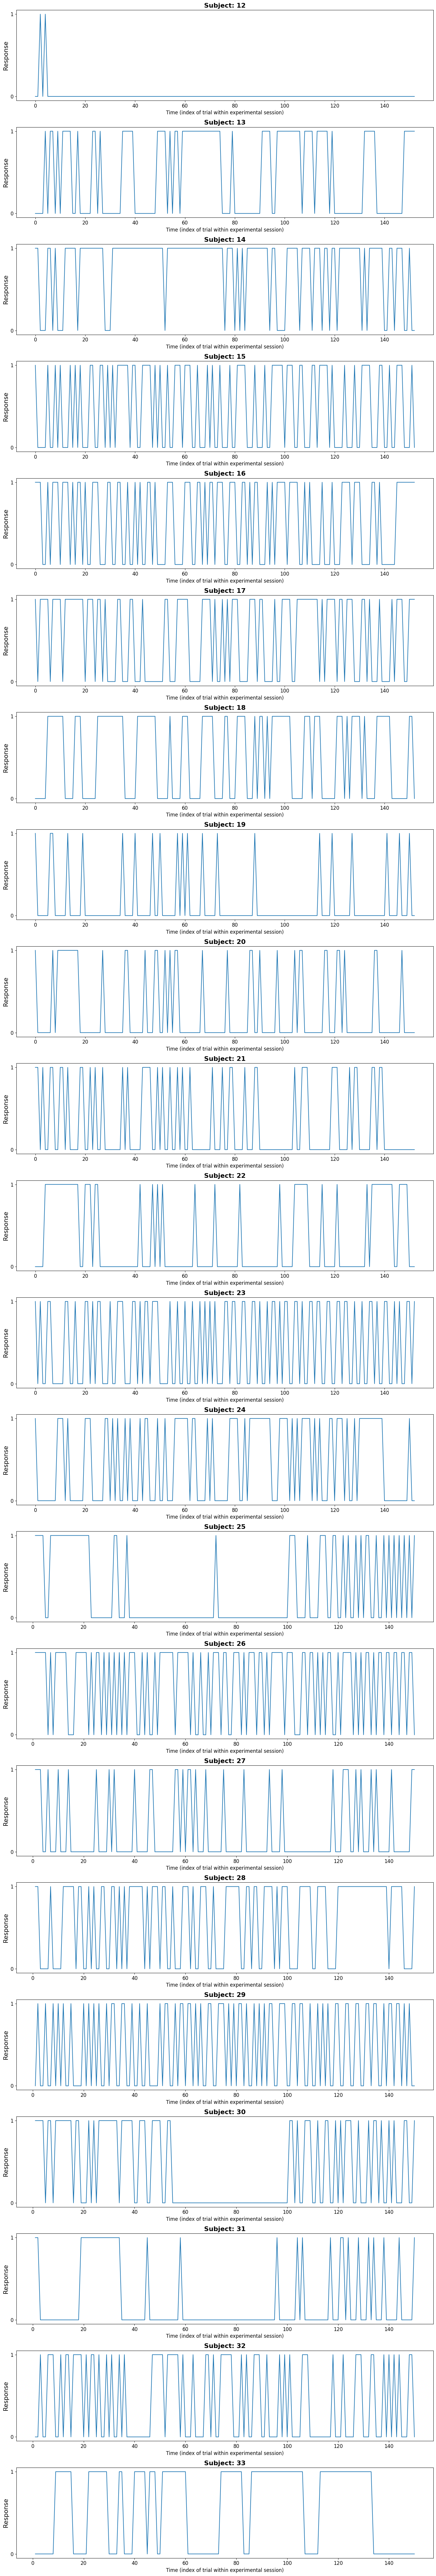

In [9]:
# Assuming revcor_data is already defined and available
patient_sessions = revcor_data[(revcor_data.type == "patients") & 
                               (revcor_data.session == 1)].groupby(["subject", "session"], as_index=False).trial.count()

num_rows = len(patient_sessions)

# Increase the figure size to make each plot larger
fig, axs = plt.subplots(num_rows, 1, figsize=(15, num_rows * 4))

for i, patient_session in enumerate(zip(patient_sessions.subject, patient_sessions.session)):
    patient = patient_session[0]
    session = patient_session[1]
    
    # Filter the data for the current patient and session
    patient_responses = revcor_data[(revcor_data.subject == patient) & 
                                    (revcor_data.session == session) & 
                                    (revcor_data.stim_order == 0)].groupby('trial')['response'].first()
    
    # Plot the patient responses for each session
    axs[i].plot(patient_responses)
    axs[i].set_yticks([0, 1])
    axs[i].set_ylabel('Response', fontsize=15)
    axs[i].set_xlabel('Time (index of trial within experimental session)', fontsize=12)
    axs[i].grid(False)
    axs[i].set_facecolor('white')
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    
    # Set the title with the subject's name at the top of the plot
    axs[i].set_title(f'Subject: {patient}', fontsize=16, fontweight='bold')

# Adjust the layout to avoid overlap between subplots
plt.tight_layout()
plt.show()

In [10]:
revcor_measures=pd.read_csv('data/revcor_measures.csv', index_col=0)
revcor_measures

index experimentor      type  subject  session  kernel_distance  \
0       0       bardet  patients       12        1         0.991552   
1       1       bardet  patients       13        1         1.506980   
2       2       bardet  patients       14        1         1.075963   
3       3       bardet  patients       15        1         0.186231   
4       4       bardet  patients       16        1         0.221178   
..    ...          ...       ...      ...      ...              ...   
63     63       ponsot  controls        7        1         0.192901   
64     64       ponsot  controls        8        1         0.115509   
65     65       ponsot  controls        9        1         0.663691   
66     66       ponsot  controls       10        1         0.506945   
67     67       ponsot  controls       11        1         0.076930   

    kernel_typicality  p_int1  pc_agree  criteria  \
0            0.699038    0.00      1.00      5.00   
1            0.534778    0.54      0.56      0.30   
2            0.672138    0.77      0.66      3.60   
3            0.955683    0.48      0.80      0.05   
4            0.944546    0.54      0.68      0.20   
..                ...     ...       ...       ...   
63           0.953558     NaN       NaN       NaN   
64           0.978221     NaN       NaN       NaN   
65           0.803523     NaN       NaN       NaN   
66           0.853476     NaN       NaN       NaN   
67           0.990516     NaN       NaN       NaN   

    internal_noise_with_criteria  accuracy  
0                           0.10  0.486667  
1                           2.15  0.553333  
2                           3.30  0.540000  
3                           0.50  0.766667  
4                           0.95  0.660000  
..                           ...       ...  
63                           NaN  0.633333  
64                           NaN  0.760000  
65                           NaN  0.513333  
66                           NaN  0.586667  
67                           NaN  0.793333  

[68 rows x 12 columns]

In [11]:
kernels=pd.read_csv('data/kernels.csv', index_col=0)
kernels

level_0  index experimentor      type  subject  session  segment  \
0          0      0       bardet  patients       12        1        0   
1          1      1       bardet  patients       12        1        1   
2          2      2       bardet  patients       12        1        2   
3          3      3       bardet  patients       12        1        3   
4          4      4       bardet  patients       12        1        4   
..       ...    ...          ...       ...      ...      ...      ...   
471      471    471       ponsot  controls       11        1        2   
472      472    472       ponsot  controls       11        1        3   
473      473    473       ponsot  controls       11        1        4   
474      474    474       ponsot  controls       11        1        5   
475      475    475       ponsot  controls       11        1        6   

     kernel_value  norm_value              new_type  
0       22.474069    1.386270  patients with MEC<=9  
1        8.660022    0.534177  patients with MEC<=9  
2        6.771886    0.417711  patients with MEC<=9  
3        1.764469    0.108838  patients with MEC<=9  
4       28.168453    1.737518  patients with MEC<=9  
..            ...         ...                   ...  
471     -6.121455   -0.311320                   NaN  
472      4.609288    0.234415                   NaN  
473      5.327733    0.270953                   NaN  
474     47.331165    2.407129                   NaN  
475     18.892003    0.960794                   NaN  

[476 rows x 10 columns]

In [12]:
revcor=revcor_data[['type','subject','block','trial','stim_order','session','segment','pitch','rt','response','experimentor']]
patients = [12, 13, 14, 19, 22, 25, 27, 28, 30, 31, 33]

revcor = revcor[(revcor.type == "patients") &  (revcor.subject.isin(patients))&(revcor.session == 1)]
revcor['response'] = revcor['response'].astype(int)

revcor

type  subject  block  trial  stim_order  session  segment  \
2142   patients       12      0      0           0        1        0   
2143   patients       12      0      0           0        1        1   
2144   patients       12      0      0           0        1        2   
2145   patients       12      0      0           0        1        3   
2146   patients       12      0      0           0        1        4   
...         ...      ...    ...    ...         ...      ...      ...   
97141  patients       31      3    150           1        1        2   
97142  patients       31      3    150           1        1        3   
97143  patients       31      3    150           1        1        4   
97144  patients       31      3    150           1        1        5   
97145  patients       31      3    150           1        1        6   

            pitch      rt  response experimentor  
2142   104.278510  36.010         0       bardet  
2143   120.742750  36.010         0       bardet  
2144   116.963717  36.010         0       bardet  
2145   -30.167489  36.010         0       bardet  
2146    58.482575  36.010         0       bardet  
...           ...     ...       ...          ...  
97141    0.292685   7.627         0       jeulin  
97142   99.188948   7.627         0       jeulin  
97143  -24.475905   7.627         0       jeulin  
97144    5.194246   7.627         0       jeulin  
97145    6.728592   7.627         0       jeulin  

[23310 rows x 11 columns]

## Response sequence of patients

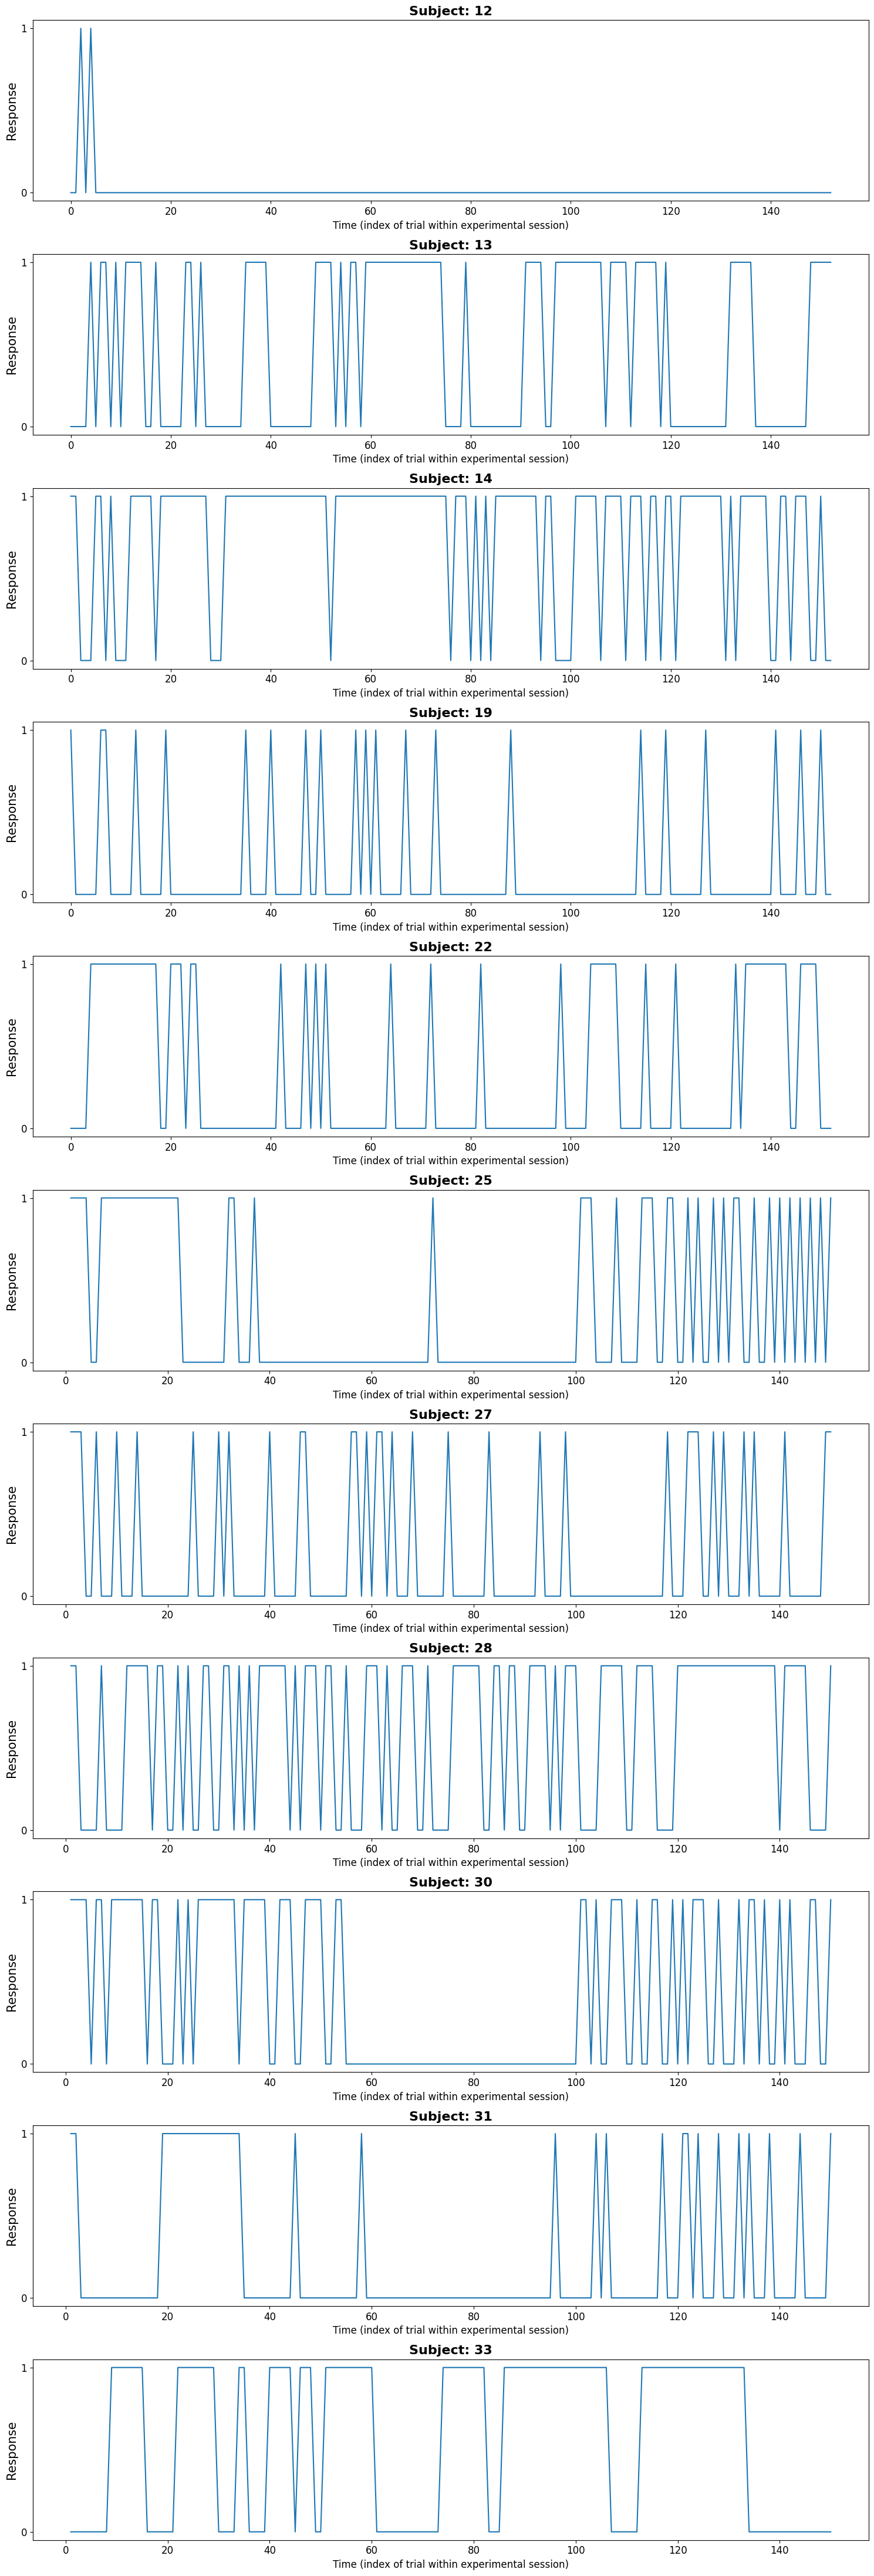

In [13]:
#patients = [12, 13, 14, 19, 22, 25, 27, 28, 30, 31, 33]

patient_sessions = revcor[(revcor.type == "patients") &  (revcor.subject.isin(patients))&
                               (revcor.session == 1)].groupby(["subject", "session"], as_index=False).trial.count()

num_rows = len(patient_sessions)

# Increase the figure size to make each plot larger
fig, axs = plt.subplots(num_rows, 1, figsize=(15, num_rows * 4))

for i, patient_session in enumerate(zip(patient_sessions.subject, patient_sessions.session)):
    patient = patient_session[0]
    session = patient_session[1]
    
    # Filter the data for the current patient and session
    patient_responses = revcor[(revcor.subject == patient) & 
                                    (revcor.session == session) & 
                                    (revcor.stim_order == 0)].groupby('trial')['response'].first()
    
    # Plot the patient responses for each session
    axs[i].plot(patient_responses)
    axs[i].set_yticks([0, 1])
    axs[i].set_ylabel('Response', fontsize=15)
    axs[i].set_xlabel('Time (index of trial within experimental session)', fontsize=12)
    axs[i].grid(False)
    axs[i].set_facecolor('white')
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    
    # Set the title with the subject's name at the top of the plot
    axs[i].set_title(f'Subject: {patient}', fontsize=16, fontweight='bold')

# Adjust the layout to avoid overlap between subplots
plt.tight_layout()
plt.show()

## Extracting kernels by GLM

In [14]:
revcor.groupby(['type','subject','experimentor']).agg({'block':'unique','trial':'nunique'})

block  trial
type     subject experimentor                     
patients 12      bardet        [0, 1, 2, 3]    153
         13      bardet        [0, 1, 2, 3]    153
         14      bardet        [0, 1, 2, 3]    153
         19      commere       [0, 1, 2, 3]    153
         22      commere       [0, 1, 2, 3]    153
         25      jeulin           [1, 2, 3]    150
         27      jeulin           [1, 2, 3]    150
         28      jeulin           [1, 2, 3]    150
         30      jeulin           [1, 2, 3]    150
         31      jeulin           [1, 2, 3]    150
         33      jeulin           [1, 2, 3]    150

In [15]:
revcor_data=pd.read_csv('data/revcor_data.csv', index_col=0, parse_dates=['date'])

revcor=revcor_data[['type','subject','block','trial','stim_order','session','segment','pitch','rt','response','experimentor']]
#patients = [12, 13, 14, 19, 22, 25, 27, 28, 30, 31, 33]

#revcor = revcor[(revcor.type == "patients") &  (revcor.subject.isin(patients))&(revcor.session == 1)]
revcor['response'] = revcor['response'].astype(int)

revcor

type  subject  block  trial  stim_order  session  segment  \
0       patients       16      0      0           0        1        0   
1       patients       16      0      0           0        1        1   
2       patients       16      0      0           0        1        2   
3       patients       16      0      0           0        1        3   
4       patients       16      0      0           0        1        4   
...          ...      ...    ...    ...         ...      ...      ...   
174841  controls       11      6    600           1        1        2   
174842  controls       11      6    600           1        1        3   
174843  controls       11      6    600           1        1        4   
174844  controls       11      6    600           1        1        5   
174845  controls       11      6    600           1        1        6   

             pitch      rt  response experimentor  
0         7.977104  12.930         1       bardet  
1        82.432249  12.930         1       bardet  
2       132.317275  12.930         1       bardet  
3       -14.753525  12.930         1       bardet  
4       -26.994032  12.930         1       bardet  
...            ...     ...       ...          ...  
174841   13.496392   1.622         0       ponsot  
174842  -30.745334   1.622         0       ponsot  
174843  -13.769432   1.622         0       ponsot  
174844   -0.266028   1.622         0       ponsot  
174845  -13.508295   1.622         0       ponsot  

[174846 rows x 11 columns]

In [16]:
pivoted_df = revcor.pivot_table(index=['type', 'subject', 'block', 'trial','stim_order','session','rt', 'response','experimentor'],
                            columns='segment',
                            values='pitch',
                            aggfunc='first').reset_index()

pivoted_df.columns = ['type', 'subject', 'block', 'trial','stim_order','session', 'rt','response','experimentor'] + [f'pitch{col}' for col in range(7)]

pivoted_df.reset_index(inplace=True, drop=True)
pivoted_df['response'] = pivoted_df['response'].astype(int)
pivoted_df=pivoted_df[(pivoted_df.session==1)&(pivoted_df.session==1)]
pivoted_df


type  subject  block  trial  stim_order  session     rt  response  \
0      controls        0      1      1           0        1  0.868         0   
2      controls        0      1      1           1        1  0.868         1   
4      controls        0      1      2           0        1  1.201         0   
6      controls        0      1      2           1        1  1.201         1   
8      controls        0      1      3           0        1  1.164         1   
...         ...      ...    ...    ...         ...      ...    ...       ...   
24958  patients       33      3    148           1        1  3.409         1   
24962  patients       33      3    149           0        1  2.302         0   
24966  patients       33      3    149           1        1  2.302         1   
24970  patients       33      3    150           0        1  7.808         0   
24974  patients       33      3    150           1        1  7.808         1   

      experimentor     pitch0      pitch1      pitch2      pitch3      pitch4  \
0           jeulin  64.335082   25.012194   19.462201   -2.760596    5.243116   
2           jeulin   7.038557    2.453242  100.632186   -1.389851    2.053347   
4           jeulin -39.960153  -15.974700   68.708502 -147.627715  -67.767149   
6           jeulin -58.312375 -130.679740  -83.105776  115.439092  -41.435679   
8           jeulin  17.480154  -63.521198   13.253487   23.370158  164.548980   
...            ...        ...         ...         ...         ...         ...   
24958       jeulin  29.001011    1.944873 -102.978964  -30.081088   10.795725   
24962       jeulin -25.525201  -59.939740  114.474724  122.921205   18.029932   
24966       jeulin -18.885660 -116.445634  -21.261117  114.606094  -26.102932   
24970       jeulin -56.861061  -81.927625   -6.810868   -3.951543   67.878107   
24974       jeulin -86.681599  128.316166   83.572368 -127.936743   14.956115   

           pitch5      pitch6  
0      -16.730048 -124.503364  
2      152.217477   39.381753  
4     -105.360249   20.899837  
6      141.103691    8.711059  
8       66.734331  -23.202349  
...           ...         ...  
24958  -92.564736   61.478651  
24962  -11.542198  -32.371835  
24966 -164.725431   42.678116  
24970   49.819815   43.145271  
24974  -19.140871  158.034797  

[14778 rows x 16 columns]

In [17]:
df = pd.DataFrame(pivoted_df)

# Assuming pitch columns are 'pitch0' to 'pitch6'
pitch_columns = ['pitch0', 'pitch1', 'pitch2', 'pitch3', 'pitch4', 'pitch5', 'pitch6']

# Separate the DataFrame into two DataFrames based on stim_order
df_stim0 = df[df['stim_order'] == 0].copy()
df_stim1 = df[df['stim_order'] == 1].copy()

# Make sure the indexes match for direct row-wise subtraction
df_stim0.set_index(['subject', 'block', 'trial', 'session'], inplace=True)
df_stim1.set_index(['subject', 'block', 'trial', 'session'], inplace=True)

# Calculate the differences for each pitch column and store in a new DataFrame
df_diff = pd.DataFrame(index=df_stim0.index)
for pitch in pitch_columns:
    df_diff[f'diff_{pitch}'] = df_stim0[pitch] - df_stim1[pitch]

# Reset index to bring the grouping columns back as normal columns
df_diff.reset_index(inplace=True)

# Assuming we want to add the 'type' column from the original DataFrame
# We'll take the 'type' from df_stim0 since it should match df_stim1 for the same group
df_diff['type'] = df_stim0['type'].values
df_diff['response_s0'] = df_stim0['response'].values
df_diff['response_s1'] = df_stim1['response'].values

df_diff.drop(columns=['response_s1'], inplace=True)
df_diff=df_diff.rename(columns={'response_s0': 'response'})
df_diff

subject  block  trial  session  diff_pitch0  diff_pitch1  diff_pitch2  \
0           0      1      1        1    57.296525    22.558952   -81.169985   
1           0      1      2        1    18.352222   114.705040   151.814278   
2           0      1      3        1   -78.731259   -10.176666    96.693678   
3           0      1      4        1    87.475958   -54.724313    40.577114   
4           0      1      5        1     5.582327   150.519672    21.759324   
...       ...    ...    ...      ...          ...          ...          ...   
7384       33      3    146        1   246.742182   -38.755183    88.022859   
7385       33      3    147        1   144.402584    58.698700   -73.716244   
7386       33      3    148        1    35.379595   110.286604    90.305739   
7387       33      3    149        1    -6.639541    56.505894   135.735841   
7388       33      3    150        1    29.820538  -210.243791   -90.383236   

      diff_pitch3  diff_pitch4  diff_pitch5  diff_pitch6      type  response  
0       -1.370745     3.189769  -168.947525  -163.885117  controls         0  
1     -263.066807   -26.331470  -246.463940    12.188778  controls         0  
2      -55.869643   174.212039    99.264377    25.138424  controls         1  
3       70.197103    73.425468   119.758598  -105.576671  controls         0  
4     -220.230883    76.064585  -226.025474   101.136959  controls         0  
...           ...          ...          ...          ...       ...       ...  
7384  -120.151641  -300.567051    46.362716    22.581438  patients         0  
7385  -190.908663   -17.699194   122.224662   -12.505070  patients         0  
7386    78.540428   -39.286023    67.284980  -106.078733  patients         0  
7387     8.315111    44.132864   153.183233   -75.049951  patients         0  
7388   123.985200    52.921992    68.960686  -114.889526  patients         0  

[7389 rows x 13 columns]

In [18]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Filter the dataset for subject 30
subject_30_data = df_diff[df_diff['subject'] == 30]

# Add a constant term to the predictors (7 pitch differences)
X = sm.add_constant(subject_30_data[['diff_pitch0', 'diff_pitch1', 'diff_pitch2', 'diff_pitch3', 'diff_pitch4', 'diff_pitch5', 'diff_pitch6']])

# Fit the logistic regression model
model = sm.Logit(subject_30_data['response'], X)
result = model.fit()

# Print the summary of the model to check the coefficients
print(result.summary())

# Generate predicted probabilities for a range of pitch differences (stimulus)
stimulus_values = np.linspace(X.iloc[:, 1:].min().min(), X.iloc[:, 1:].max().max(), 300)
mean_pitch_diffs = np.mean(subject_30_data[['diff_pitch0', 'diff_pitch1', 'diff_pitch2', 'diff_pitch3', 'diff_pitch4', 'diff_pitch5', 'diff_pitch6']], axis=1)

# Create an input matrix for predictions (using mean pitch differences)
mean_pitch_diff_values = sm.add_constant(np.tile(stimulus_values, (7, 1)).T)

# Predict the probabilities using the fitted model
y_pred = result.predict(mean_pitch_diff_values)




Optimization terminated successfully.
         Current function value: 0.648367
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               response   No. Observations:                  150
Model:                          Logit   Df Residuals:                      142
Method:                           MLE   Df Model:                            7
Date:                Mon, 07 Oct 2024   Pseudo R-squ.:                 0.04693
Time:                        16:03:24   Log-Likelihood:                -97.255
converged:                       True   LL-Null:                       -102.04
Covariance Type:            nonrobust   LLR p-value:                    0.2138
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2689      0.172     -1.560      0.119      -0.607       0.069
diff_pitch0    -0.0016    

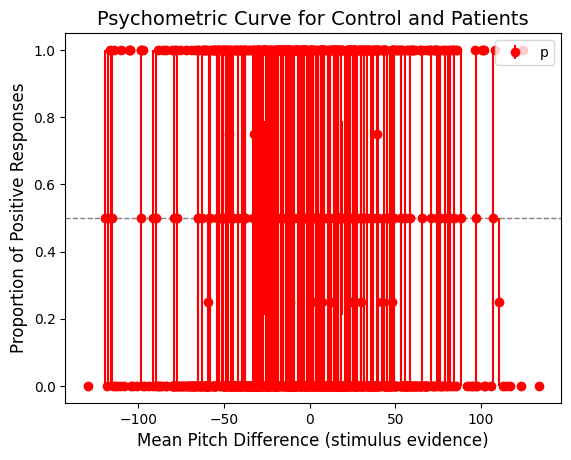

In [19]:
def plot_data_psychometric_pitch(df):
    """
    Plots the psychometric function based on pitch differences.
    Args:
       df (dataframe): dataset.
    """
    # Compute mean pitch difference per trial (averaging across the 7 pitch segments)
    df_diff['mean_pitch_diff'] = df_diff[['diff_pitch0', 'diff_pitch1', 'diff_pitch2', 'diff_pitch3', 'diff_pitch4', 'diff_pitch5', 'diff_pitch6']].mean(axis=1)
    
    # Plot psychometric curve for manipulation (patients) trials
    mask = df_diff['type'] == 'patients'  # select patient trials
    patient_data = df_diff[mask].groupby('mean_pitch_diff')['response'].agg(['mean', 'sem'])
    patient_data.plot(y='mean', yerr='sem', fmt='ro', ax=plt.gca(), legend=False)

    # Add labels and legends
    plt.legend(('patients'), loc='best')
    plt.xlabel('Mean Pitch Difference (stimulus evidence)', fontsize=12)
    plt.ylabel('Proportion of Positive Responses', fontsize=12)
    plt.title('Psychometric Curve for Control and Patients', fontsize=14)
    plt.axhline(0.5, color='gray', linestyle='--', lw=1)  # Add reference line at 0.5
    plt.show()

# Apply the function to your dataframe 
plot_data_psychometric_pitch(df_diff)


## regression by Palin

In [18]:
def compute_kernel_CI(data_df, trial_ids=['experimentor', 'type', 'subject', 'session'],
                      dimension_id='segment', response_id='response', value_id='pitch'):
    # Grouping by trial_ids and dimension_id, and calculating the mean of value_id
    dimension_mean_value = data_df.groupby(trial_ids + [dimension_id, response_id])[value_id].mean().reset_index()

    # Separating the positives and negatives
    positives = dimension_mean_value.loc[dimension_mean_value[response_id] == True].reset_index()
    negatives = dimension_mean_value.loc[dimension_mean_value[response_id] == False].reset_index()

    # Merging positives and negatives and computing kernel values
    kernels = pd.merge(positives, negatives, on=trial_ids + [dimension_id])
    kernels['kernel_value'] = kernels[f'{value_id}_x'] - kernels[f'{value_id}_y']

    # Normalizing the kernels
    kernels['square_value'] = kernels['kernel_value'] ** 2
    for_norm = kernels.groupby(trial_ids)['square_value'].mean().reset_index()
    kernels = pd.merge(kernels, for_norm, on=trial_ids)
    kernels['norm_value'] = kernels['kernel_value'] / np.sqrt(kernels['square_value_y'])

    # Dropping unnecessary columns
    drop_cols = ['index_x', f'{response_id}_x', f'{value_id}_x', 'index_y', f'{response_id}_y', f'{value_id}_y', 'square_value_x', 'square_value_y']
    kernels.drop(columns=drop_cols, inplace=True)

    return kernels


In [19]:
# Assuming revcor_data is your DataFrame
kernels_ci = compute_kernel_CI(data_df=revcor_data[(revcor_data.type == "patients") &  (revcor_data.subject.isin(patients))&(revcor_data.session == 1)], 
                               trial_ids=['experimentor', 'type', 'subject', 'session'], 
                               dimension_id='segment', 
                               response_id='response', 
                               value_id='pitch')
kernels_ci

experimentor      type  subject  session  segment  kernel_value  norm_value
0        bardet  patients       12        1        0     23.869609    1.501039
1        bardet  patients       12        1        1      7.759669    0.487966
2        bardet  patients       12        1        2      5.036506    0.316720
3        bardet  patients       12        1        3     -0.177330   -0.011151
4        bardet  patients       12        1        4     25.780560    1.621209
..          ...       ...      ...      ...      ...           ...         ...
72       jeulin  patients       33        1        2     -7.660812   -0.827034
73       jeulin  patients       33        1        3      5.354820    0.578087
74       jeulin  patients       33        1        4     -4.940444   -0.533353
75       jeulin  patients       33        1        5     21.542379    2.325639
76       jeulin  patients       33        1        6      3.550320    0.383280

[77 rows x 7 columns]

In [20]:
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
def compute_kernel(data_df, method='glm', level='per_stim'):
    # Check and convert 'response' to numeric if it's boolean
    if data_df['response'].dtype == bool:
        data_df['response'] = data_df['response'].astype(int)
    
    # Convert categorical binary responses to 0/1
    if not pd.api.types.is_numeric_dtype(data_df['response']):
        unique_responses = data_df['response'].unique()
        if len(unique_responses) == 2:
            mapping = {unique_responses[0]: 0, unique_responses[1]: 1}
            data_df['response'] = data_df['response'].map(mapping).astype(int)
        else:
            raise ValueError("The response column must be binary (0 or 1).")

    # Create formula based on the level
    if level == 'per_stim':
        predictors = ' + '.join([f'pitch{i}' for i in range(7)])
    elif level == 'per_trial':
        predictors = ' + '.join([f'diff_pitch{i}' for i in range(7)])
    else:
        raise ValueError("Invalid level specified. Choose 'per_stim' or 'per_trial'.")

    # Explicitly include a bias/intercept term in the formula by adding "+ 1"
    formula = f"response ~ {predictors}"  # "+ 1" ensures the intercept is included

    # Fit the model with GLM and regularization (L2 as an example)
    if method == 'glm':
        model = smf.glm(formula=formula, data=data_df, family=Binomial()).fit()  # L2 Regularization
        raw_residuals = model.resid_response
        pearson_residuals = model.resid_pearson
        deviance_residuals = model.resid_deviance
        working_residuals = model.resid_working
        return model, raw_residuals, pearson_residuals, deviance_residuals, working_residuals
    else:
        raise ValueError("Invalid method selected. Choose 'glm'.")

In [21]:
def compute_and_store_coefs(methods_levels, data_dict):
    all_coef_dfs = []

    for method_name, level in methods_levels.items():
        df_to_use = data_dict[level]  # Use the appropriate DataFrame based on 'per_stim' or 'per_trial'
        
        all_coef_df = pd.DataFrame()  # Reset for each method
        for subject in df_to_use['subject'].unique():
            subject_data = df_to_use[df_to_use['subject'] == subject]
            # Use 'glm' method as the only available method in compute_kernel
            model_results = compute_kernel(subject_data, method='glm', level=level)[0]

            # Extract coefficients and other relevant statistics
            coefs = pd.DataFrame({
                'coef': model_results.params.index,
                'value': model_results.params.values,
                'p_value': model_results.pvalues,
                'CI_lower': model_results.conf_int()[0],
                'CI_upper': model_results.conf_int()[1],
                'subject': subject,
                'method': method_name  # Add method name for identification
            })
            all_coef_df = pd.concat([all_coef_df, coefs], ignore_index=True)

        all_coef_dfs.append(all_coef_df)

    final_coef_df = pd.concat(all_coef_dfs, ignore_index=True)
    return final_coef_df

# Example usage
methods_levels = {
    'glm_stim': 'per_stim',
    'glm_trial': 'per_trial'
}

# Assuming pivoted_df and df_diff are already defined as the data frames
data_dict = {
    'per_stim': pivoted_df,
    'per_trial': df_diff
}

final_coef_df = compute_and_store_coefs(methods_levels, data_dict)
final_coef_df

coef     value   p_value  CI_lower  CI_upper  subject     method
0      Intercept -0.054791  0.711335 -0.344983  0.235400        0   glm_stim
1         pitch0 -0.002514  0.208116 -0.006428  0.001400        0   glm_stim
2         pitch1  0.001007  0.572639 -0.002492  0.004506        0   glm_stim
3         pitch2  0.001495  0.439504 -0.002295  0.005285        0   glm_stim
4         pitch3 -0.005870  0.001209 -0.009424 -0.002316        0   glm_stim
..           ...       ...       ...       ...       ...      ...        ...
539  diff_pitch2 -0.000929  0.532094 -0.003844  0.001985       33  glm_trial
540  diff_pitch3  0.000566  0.716358 -0.002487  0.003619       33  glm_trial
541  diff_pitch4 -0.000329  0.836214 -0.003445  0.002788       33  glm_trial
542  diff_pitch5  0.002524  0.071228 -0.000218  0.005267       33  glm_trial
543  diff_pitch6  0.000505  0.749970 -0.002599  0.003608       33  glm_trial

[544 rows x 7 columns]

In [22]:
# Compute and store the residuals for each method
def compute_and_store_residuals(methods_levels, data_dict, kernels_ci):
    all_residuals_dfs = []

    for method_name, level in methods_levels.items():
        df_to_use = data_dict[level]
        method_type = 'glm' if 'glm' in method_name else 'lm'

        for subject in df_to_use['subject'].unique():
            subject_data = df_to_use[df_to_use['subject'] == subject]
            _, raw_residuals, pearson_residuals, deviance_residuals, working_residuals = compute_kernel(subject_data, method=method_type, level=level)

            # Store residuals for this subject and method
            residuals_df = pd.DataFrame({
                'subject': subject,
                'method': method_name,
                'raw_residuals': raw_residuals,
                'pearson_residuals': pearson_residuals,
                'deviance_residuals': deviance_residuals,
                'working_residuals': working_residuals
            })
            all_residuals_dfs.append(residuals_df)

    final_residuals_df = pd.concat(all_residuals_dfs, ignore_index=True)

    # Map the 'type' from 'kernels_ci' DataFrame
    type_dict = kernels_ci.set_index('subject')['type'].to_dict()
    final_residuals_df['type'] = final_residuals_df['subject'].map(type_dict)

    return final_residuals_df

# Example usage
final_residuals_df = compute_and_store_residuals(methods_levels, data_dict, kernels_ci)
final_residuals_df

subject     method  raw_residuals  pearson_residuals  \
0            0   glm_stim      -0.254904          -0.584901   
1            0   glm_stim       0.040798           0.206236   
2            0   glm_stim      -0.233678          -0.552209   
3            0   glm_stim       0.159857           0.436203   
4            0   glm_stim       0.165238           0.444911   
...        ...        ...            ...                ...   
22162       33  glm_trial      -0.559629          -1.127302   
22163       33  glm_trial      -0.609776          -1.250053   
22164       33  glm_trial      -0.572491          -1.157208   
22165       33  glm_trial      -0.607134          -1.243141   
22166       33  glm_trial      -0.623306          -1.286342   

       deviance_residuals  working_residuals      type  
0               -0.767128          -1.342109       NaN  
1                0.288630           1.042533       NaN  
2               -0.729593          -1.304934       NaN  
3                0.590225           1.190273       NaN  
4                0.601013           1.197946       NaN  
...                   ...                ...       ...  
22162           -1.280732          -2.270811  patients  
22163           -1.371885          -2.562632  patients  
22164           -1.303671          -2.339130  patients  
22165           -1.366958          -2.545398  patients  
22166           -1.397371          -2.654675  patients  

[22167 rows x 7 columns]

In [23]:
# Assuming final_residuals_df contains columns 'raw_residuals', 'pearson_residuals', 'deviance_residuals', 'working_residuals'

# Calculate the standard deviation of residuals for each subject, type, and method
std_residuals_raw = final_residuals_df.groupby(['subject', 'type','method'])['raw_residuals'].std().reset_index().rename(columns={'raw_residuals': 'std_raw'})
std_residuals_pearson = final_residuals_df.groupby(['subject', 'type','method'])['pearson_residuals'].std().reset_index().rename(columns={'pearson_residuals': 'std_pearson'})
std_residuals_deviance = final_residuals_df.groupby(['subject', 'type','method'])['deviance_residuals'].std().reset_index().rename(columns={'deviance_residuals': 'std_deviance'})
std_residuals_working = final_residuals_df.groupby(['subject', 'type','method'])['working_residuals'].std().reset_index().rename(columns={'working_residuals': 'std_working'})

# Merge all the standard deviations into a single DataFrame
std_residuals_df = pd.merge(std_residuals_raw, std_residuals_pearson, on=['subject', 'type', 'method'])
std_residuals_df = pd.merge(std_residuals_df, std_residuals_deviance, on=['subject', 'type', 'method'])
std_residuals_df = pd.merge(std_residuals_df, std_residuals_working, on=['subject', 'type', 'method'])
std_residuals_df

subject      type     method   std_raw  std_pearson  std_deviance  \
0        12  patients   glm_stim  0.487251     1.001900      1.155997   
1        12  patients  glm_trial  0.094952     1.254670      0.313391   
2        13  patients   glm_stim  0.483175     1.002910      1.149147   
3        13  patients  glm_trial  0.470622     1.013028      1.129418   
4        14  patients   glm_stim  0.497729     1.001642      1.174068   
5        14  patients  glm_trial  0.418759     0.993474      1.018602   
6        19  patients   glm_stim  0.489148     1.001458      1.159113   
7        19  patients  glm_trial  0.331819     1.049941      0.843223   
8        22  patients   glm_stim  0.492243     1.002294      1.164810   
9        22  patients  glm_trial  0.456442     1.002153      1.095657   
10       25  patients   glm_stim  0.497069     1.001672      1.172941   
11       25  patients  glm_trial  0.455135     1.007716      1.093782   
12       27  patients   glm_stim  0.489089     1.001554      1.159038   
13       27  patients  glm_trial  0.397351     1.023665      0.978844   
14       28  patients   glm_stim  0.498764     1.001557      1.175801   
15       28  patients  glm_trial  0.484751     1.003271      1.149851   
16       30  patients   glm_stim  0.491299     1.001539      1.162892   
17       30  patients  glm_trial  0.480180     1.000191      1.141461   
18       31  patients   glm_stim  0.497859     1.001756      1.174333   
19       31  patients  glm_trial  0.405916     0.998130      0.994145   
20       33  patients   glm_stim  0.495646     1.001713      1.170520   
21       33  patients  glm_trial  0.489548     1.001483      1.158765   

    std_working  
0      2.064617  
1     19.284516  
2      2.090308  
3      2.224274  
4      2.015987  
5      2.380328  
6      2.054133  
7      4.283890  
8      2.043689  
9      2.227070  
10     2.018961  
11     2.287694  
12     2.054914  
13     3.036835  
14     2.011322  
15     2.080018  
16     2.044470  
17     2.096386  
18     2.015928  
19     2.544498  
20     2.025112  
21     2.051278

In [25]:
# Filter out intercept rows from final_coef_df
final_coef_df_filtered=final_coef_df[final_coef_df['coef'] != 'Intercept']
final_coef_df_filtered['value'] = final_coef_df_filtered['value'].astype(float)
kernels_ci=kernels_ci[kernels_ci.session==1]
kernels_ci['method'] = 'CI'
kernels_ci=kernels_ci.rename(columns={'norm_value': 'value','segment':'coef'})
kernels_ci['value'] = kernels_ci['value'].astype(float)
kernels_ci['coef'] = kernels_ci['coef'].astype(str)
final_coef_df_filtered['coef'] = final_coef_df_filtered['coef'].astype(str)
# Create a dictionary from 'kernels_ci' mapping 'subject' to 'type'
type_dict = kernels_ci.set_index('subject')['type'].to_dict()

# Map the 'type' to 'final_coef_df_filtered' using the 'subject' column
final_coef_df_filtered['type'] = final_coef_df_filtered['subject'].map(type_dict)



merged_df = pd.merge(final_coef_df_filtered, kernels_ci, 
                     on=['subject', 'value', 'coef','method','type'],
                     how='outer')
# Now you can proceed with your merge, and 'final_coef_df_filtered' will have the 'type' column

merged_df['segment'] = merged_df['coef'].str.extract('(\d+)$').astype(int)
columns_to_drop = ['p_value', 'CI_lower', 'CI_upper', 'experimentor', 'session', 'kernel_value','coef']
# Drop the columns
merged_df.drop(columns=columns_to_drop, inplace=True)
merged_df

<>:23: DeprecationWarning: invalid escape sequence \d
<>:23: DeprecationWarning: invalid escape sequence \d
G:\Utilisateurs\aynaz.adlzarrabi\AppData\Local\Temp\ipykernel_19276\2144795512.py:23: DeprecationWarning: invalid escape sequence \d
  merged_df['segment'] = merged_df['coef'].str.extract('(\d+)$').astype(int)


value  subject    method      type  segment
0   -0.002514        0  glm_stim       NaN        0
1    0.001007        0  glm_stim       NaN        1
2    0.001495        0  glm_stim       NaN        2
3   -0.005870        0  glm_stim       NaN        3
4    0.004653        0  glm_stim       NaN        4
..        ...      ...       ...       ...      ...
548 -0.827034       33        CI  patients        2
549  0.578087       33        CI  patients        3
550 -0.533353       33        CI  patients        4
551  2.325639       33        CI  patients        5
552  0.383280       33        CI  patients        6

[553 rows x 5 columns]

Processing patient 12


  0%|          | 0/1000 [00:00<?, ?it/s]

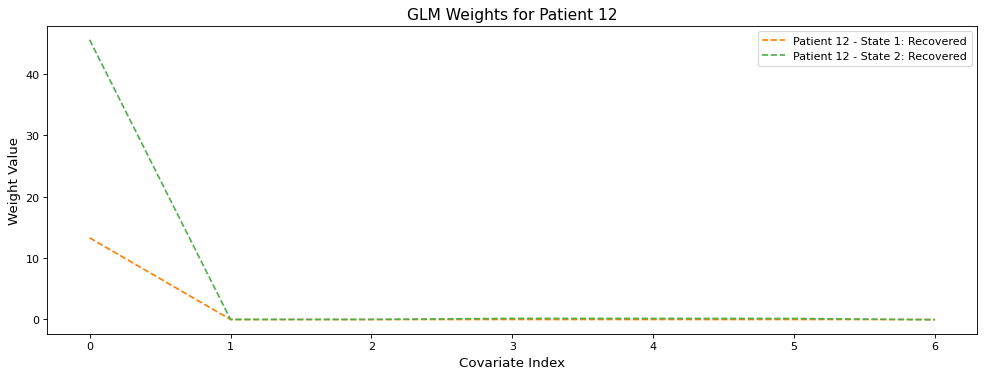

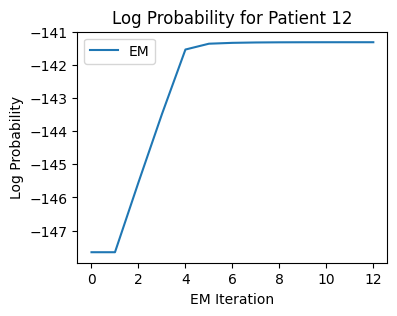

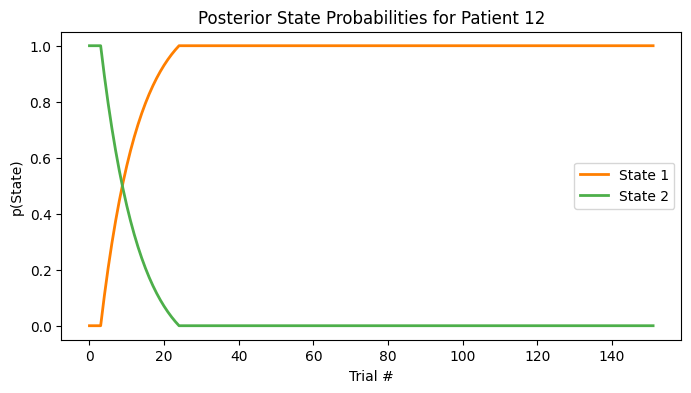

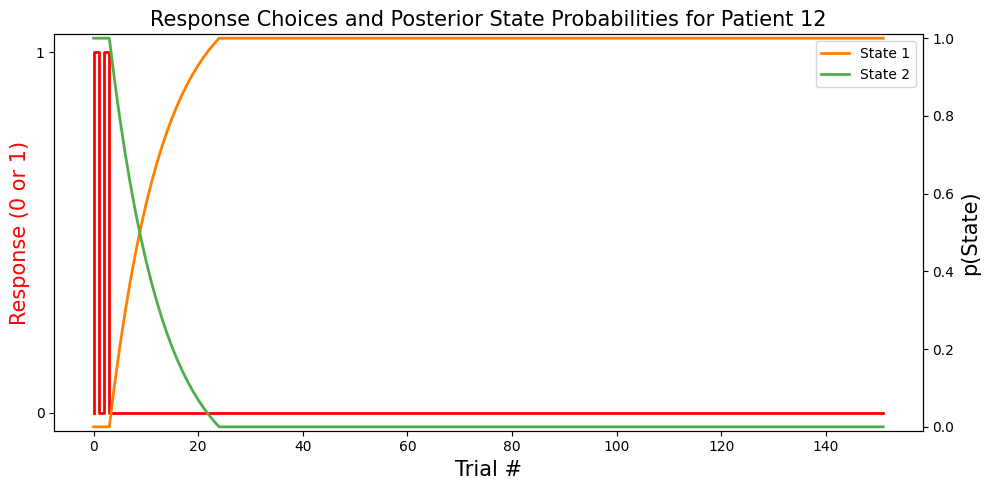

Processing patient 13


  0%|          | 0/1000 [00:00<?, ?it/s]

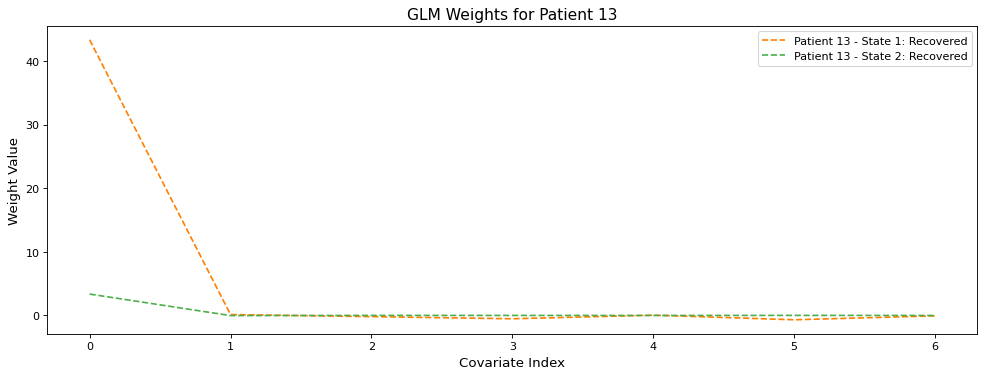

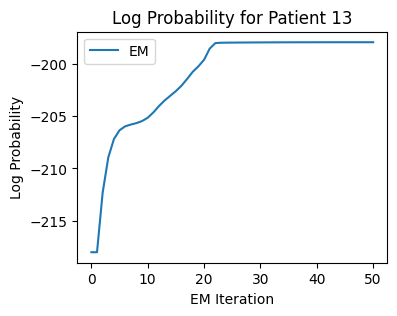

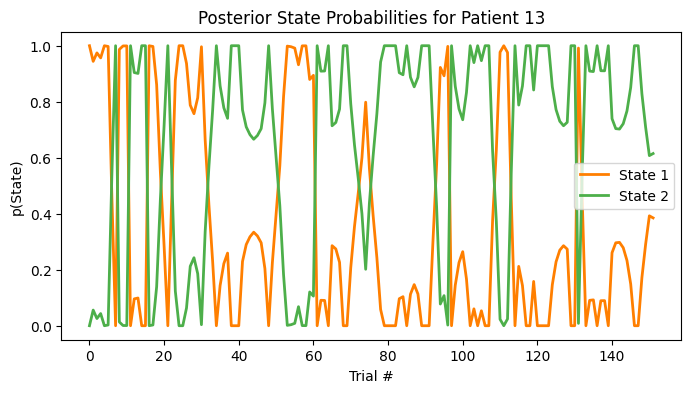

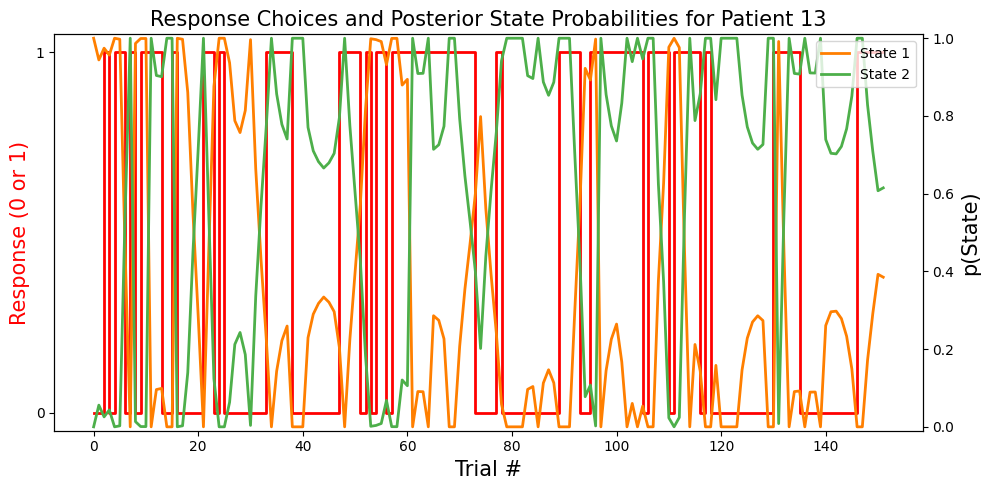

Processing patient 14


  0%|          | 0/1000 [00:00<?, ?it/s]

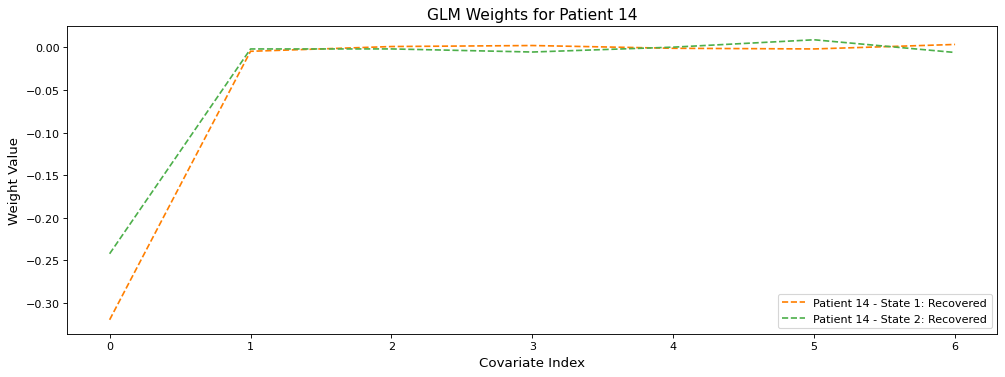

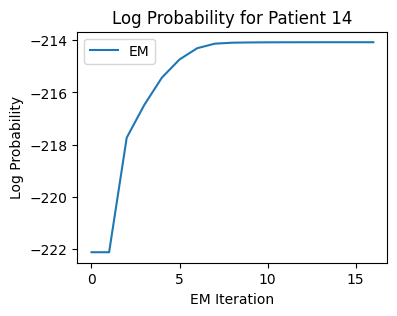

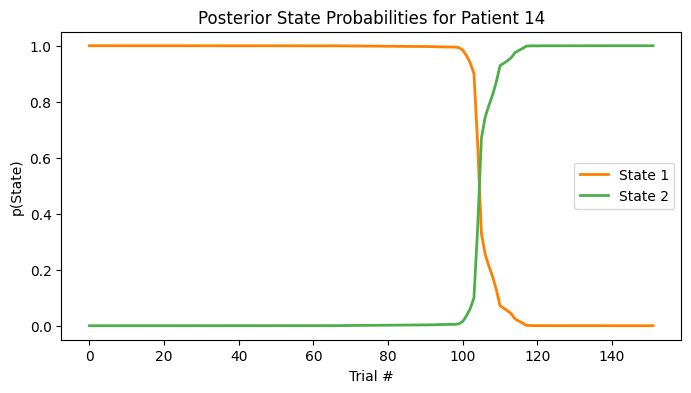

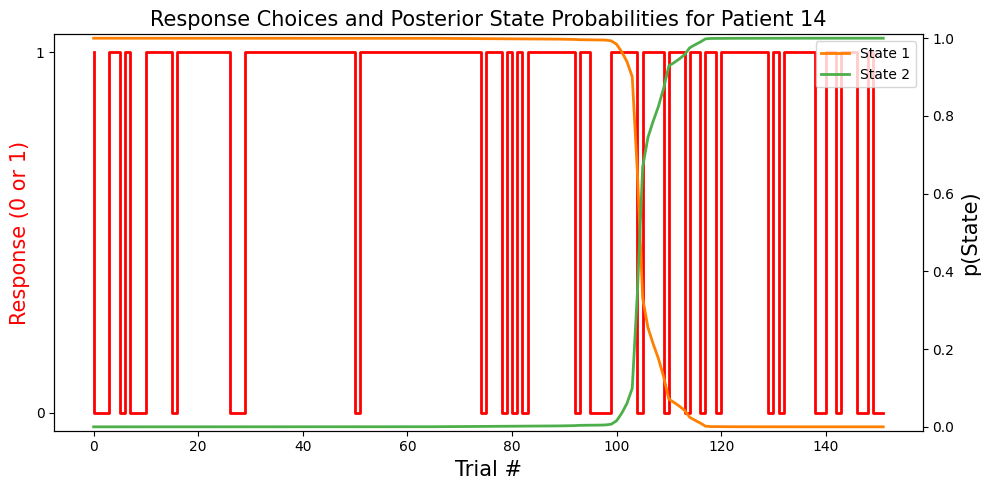

Processing patient 19


  0%|          | 0/1000 [00:00<?, ?it/s]

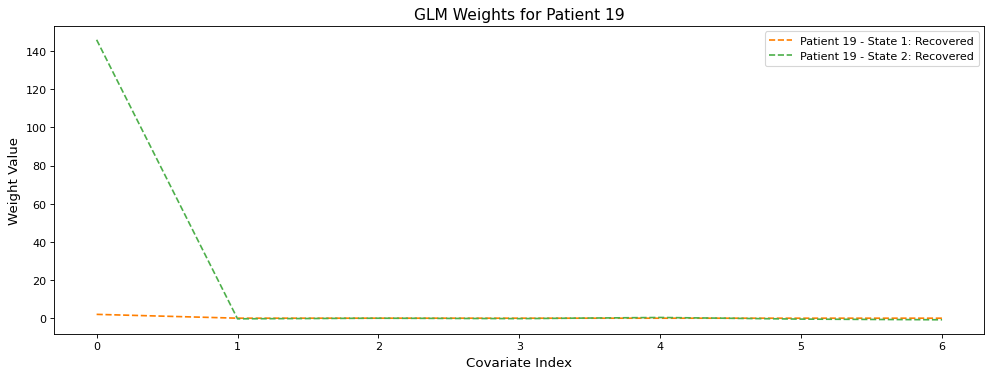

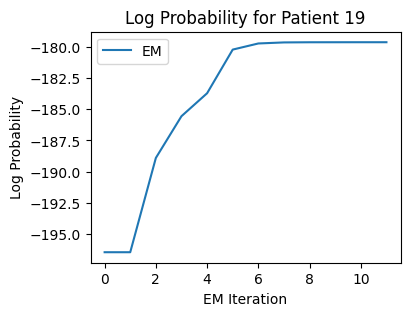

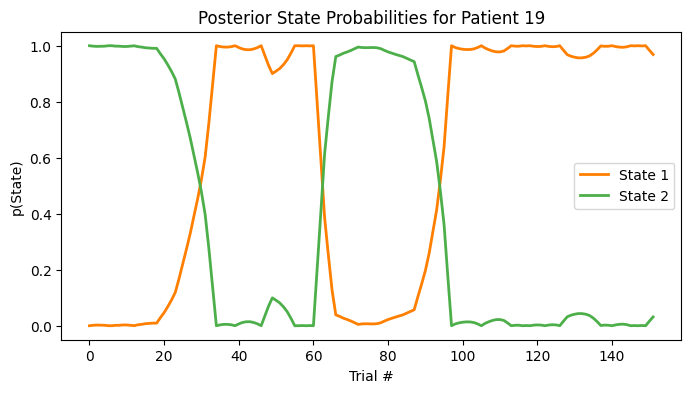

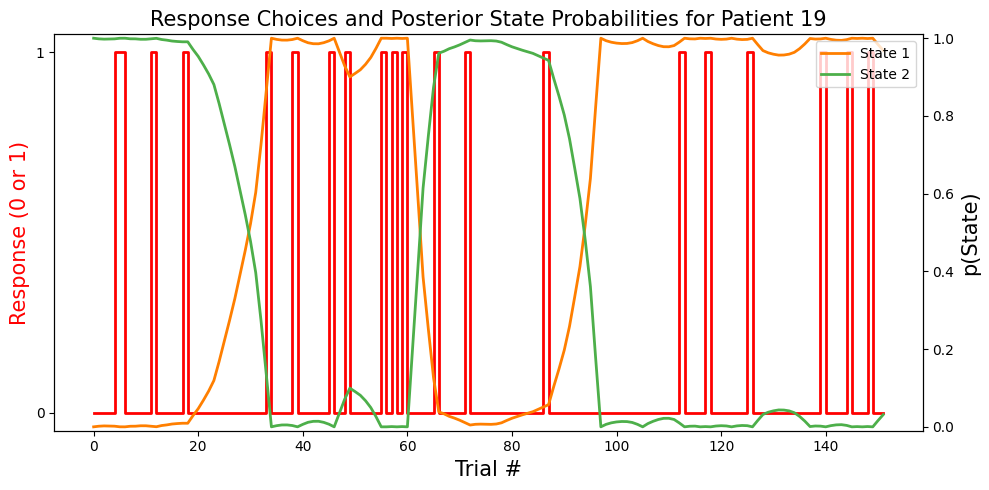

Processing patient 22


  0%|          | 0/1000 [00:00<?, ?it/s]

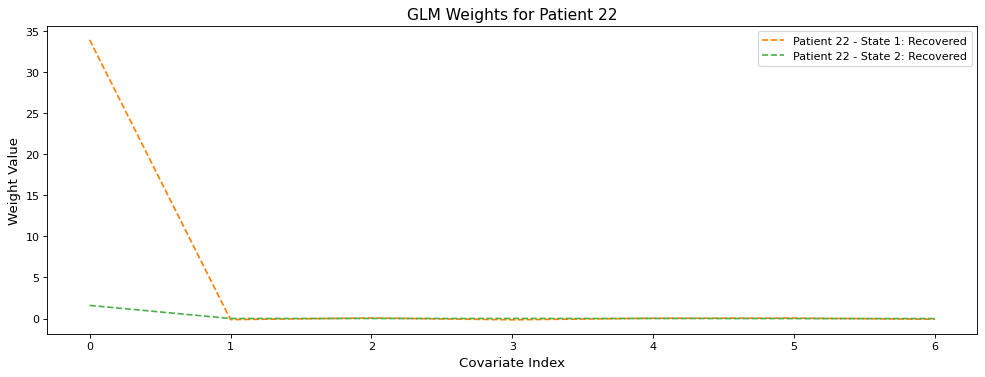

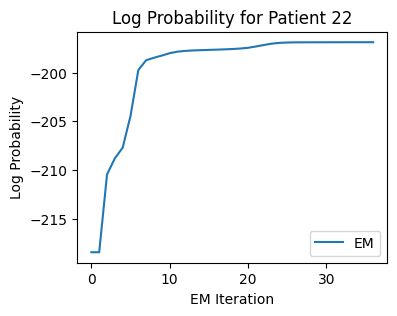

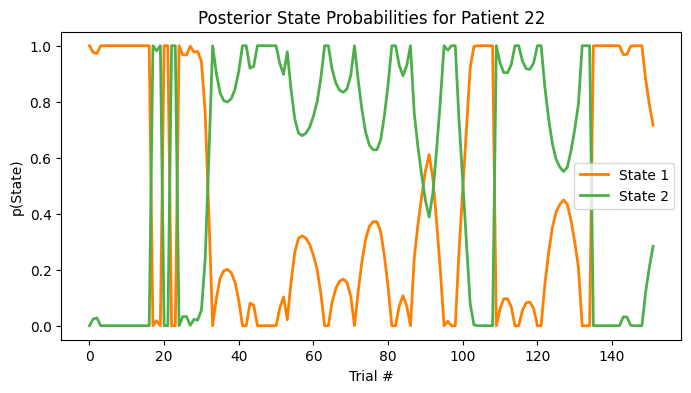

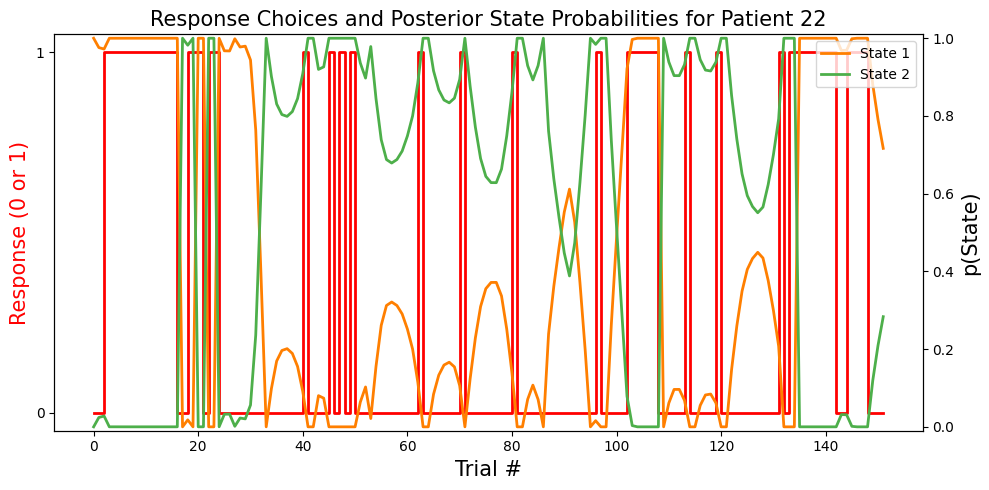

Processing patient 25


  0%|          | 0/1000 [00:00<?, ?it/s]

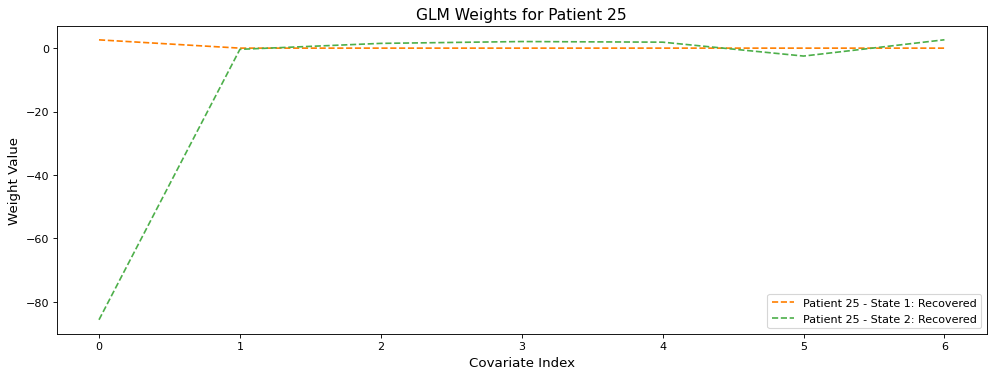

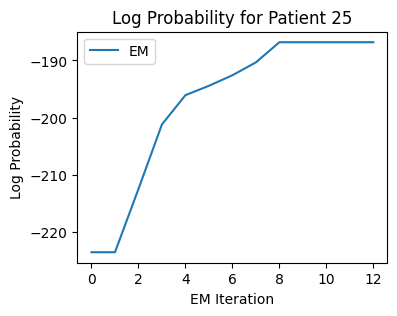

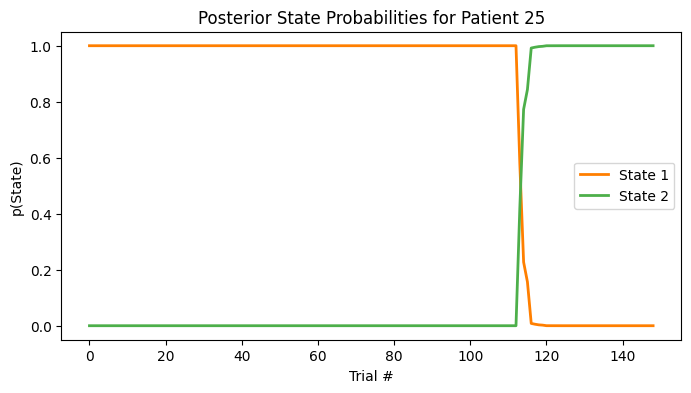

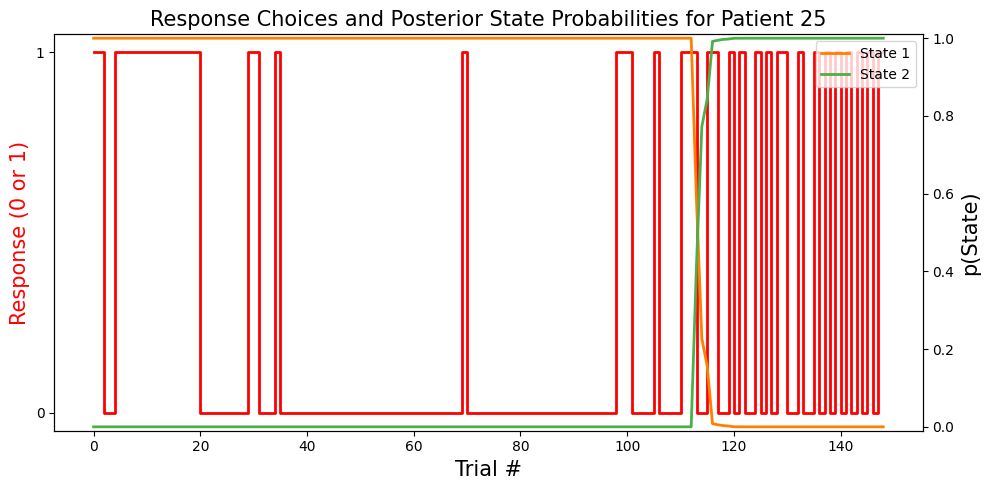

Processing patient 27


  0%|          | 0/1000 [00:00<?, ?it/s]

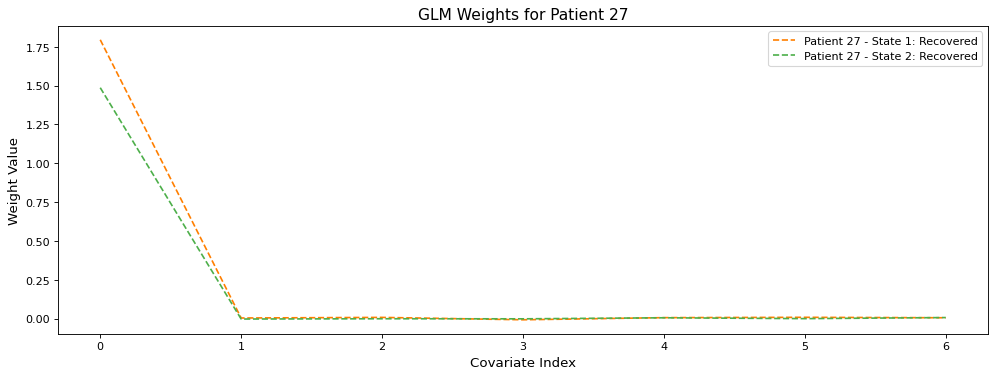

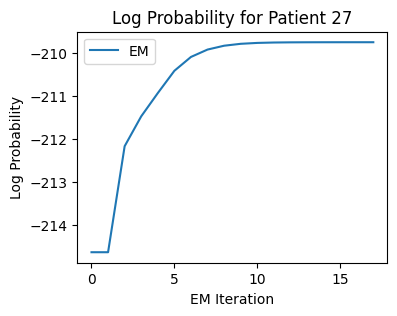

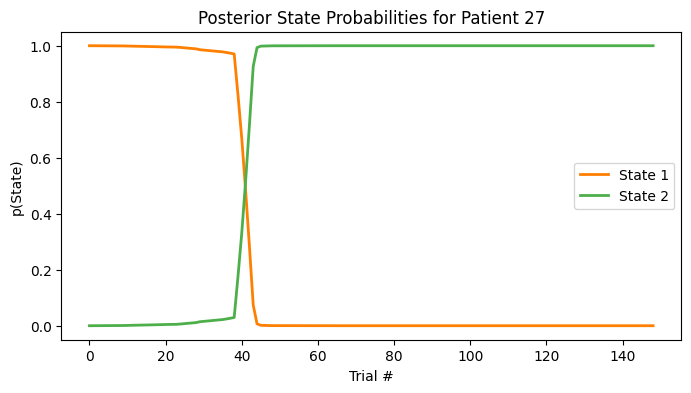

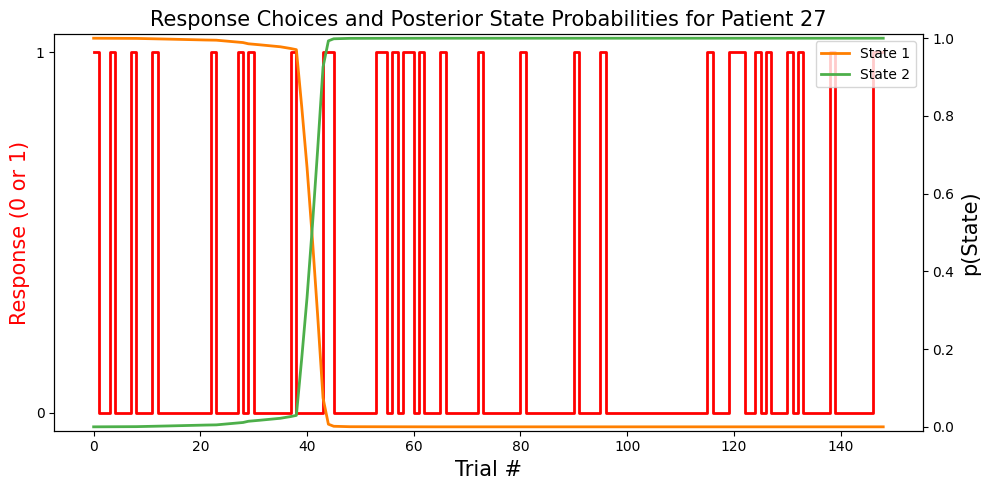

Processing patient 28


  0%|          | 0/1000 [00:00<?, ?it/s]

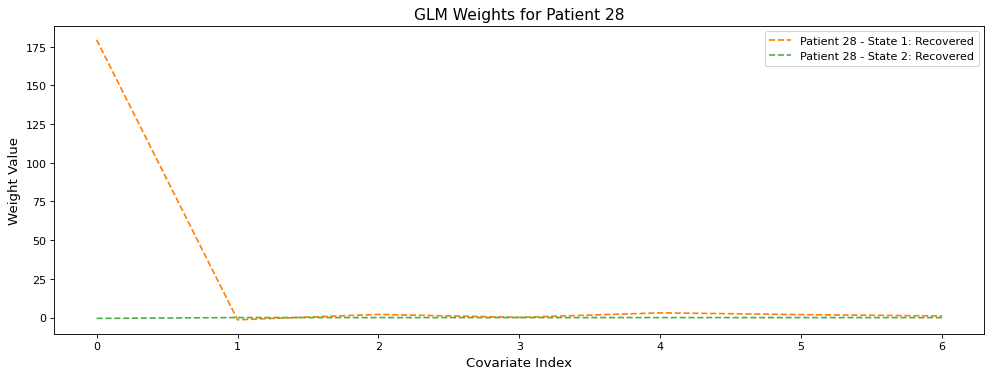

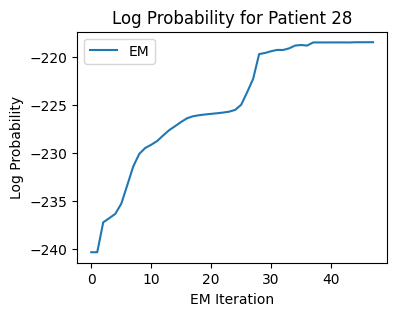

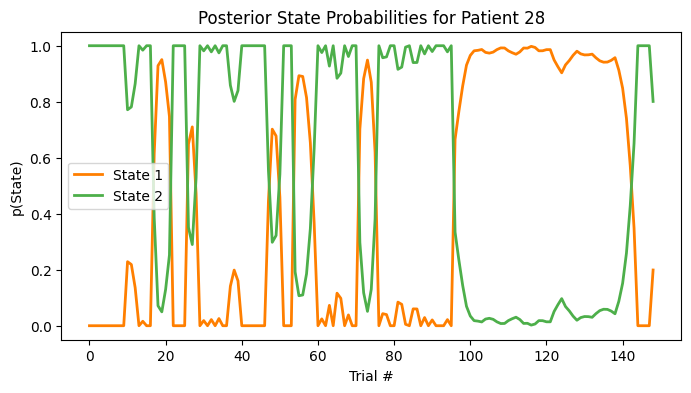

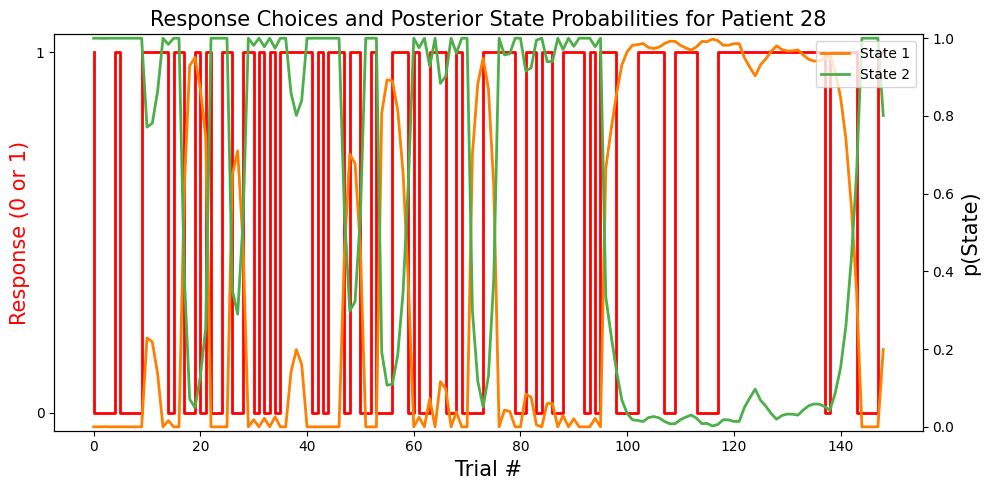

Processing patient 30


  0%|          | 0/1000 [00:00<?, ?it/s]

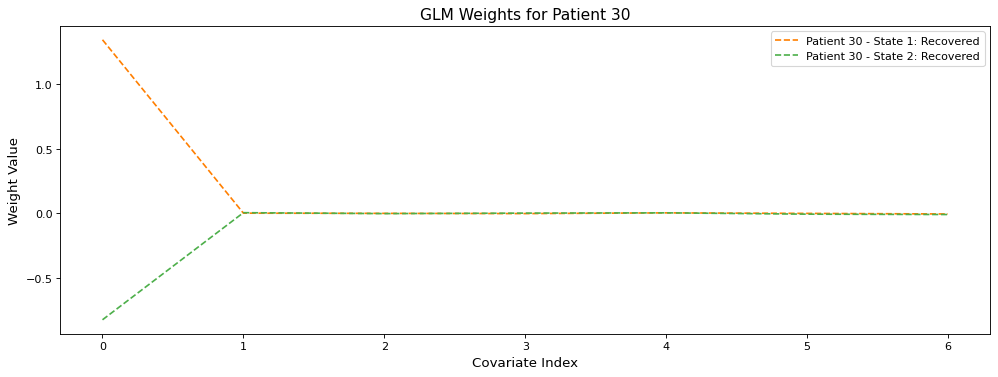

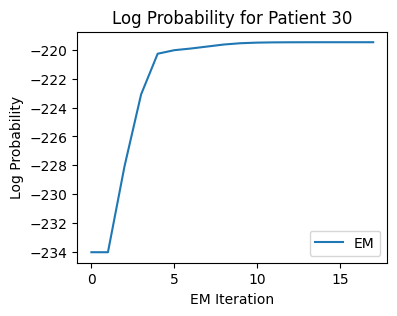

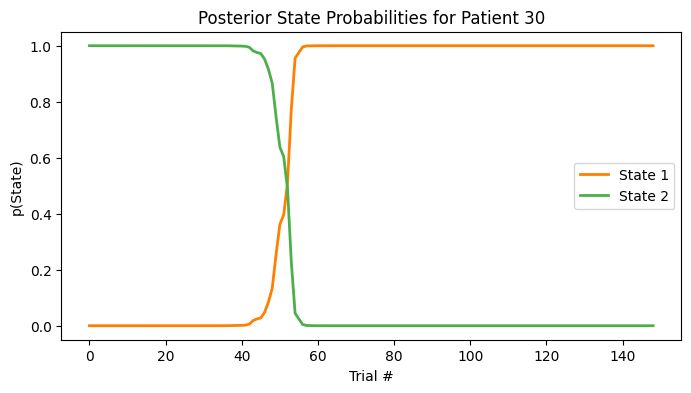

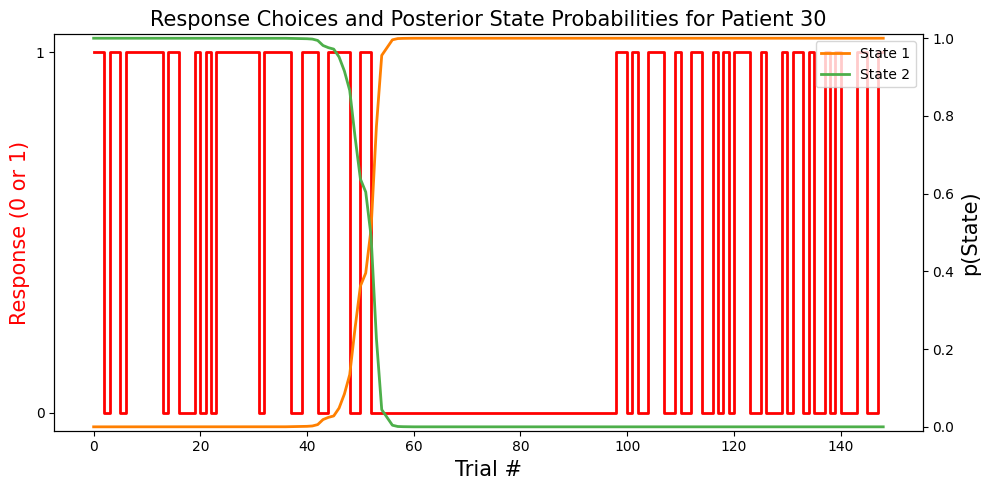

Processing patient 31


  0%|          | 0/1000 [00:00<?, ?it/s]

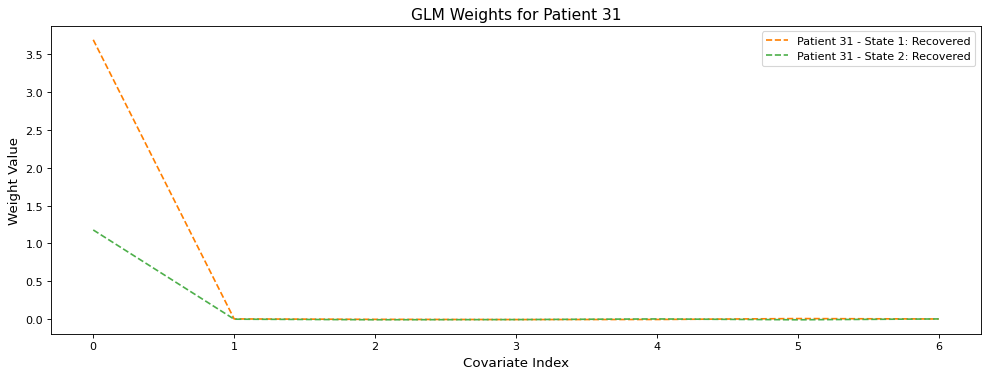

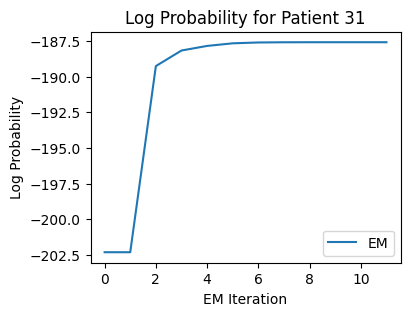

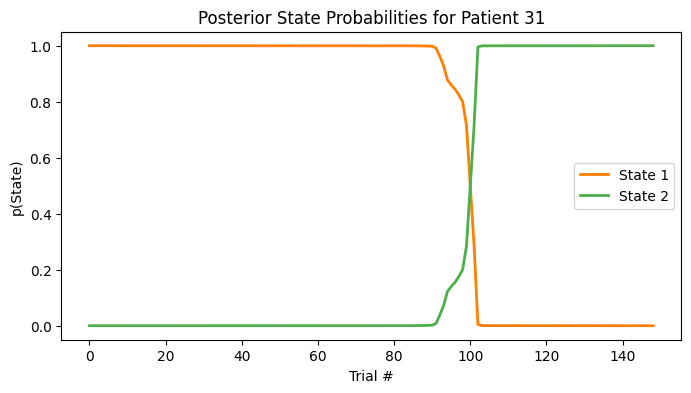

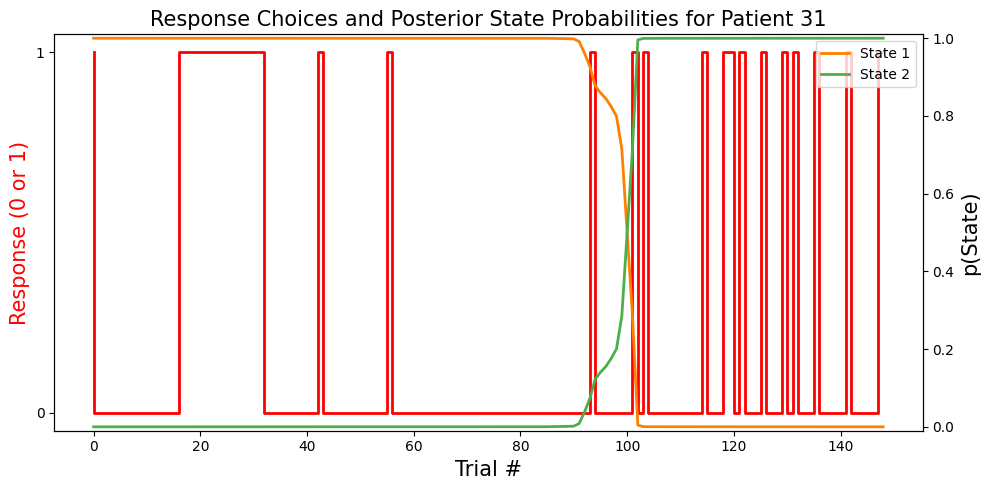

Processing patient 33


  0%|          | 0/1000 [00:00<?, ?it/s]

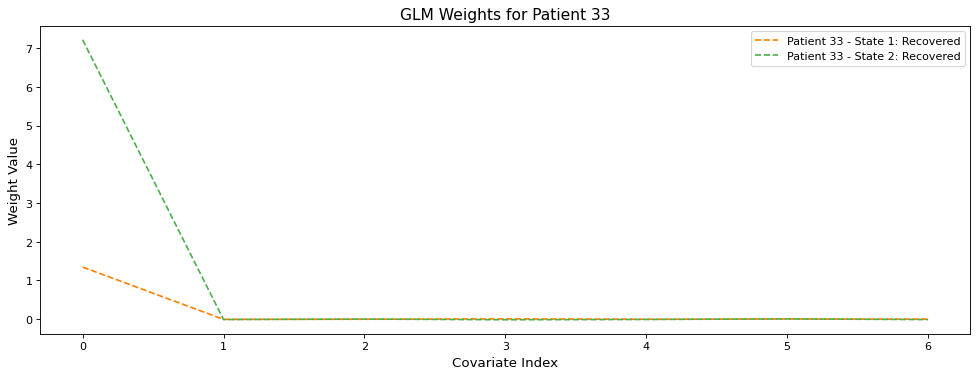

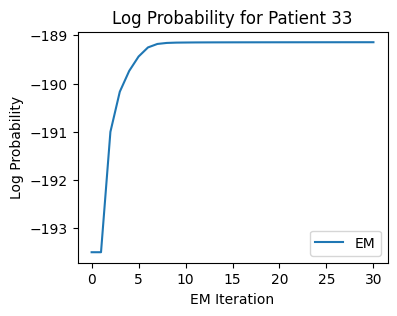

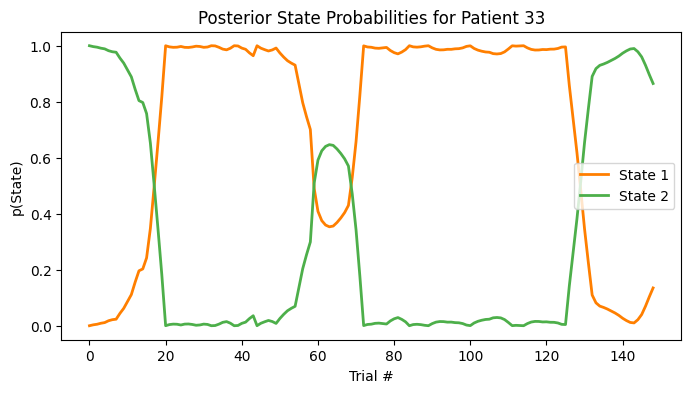

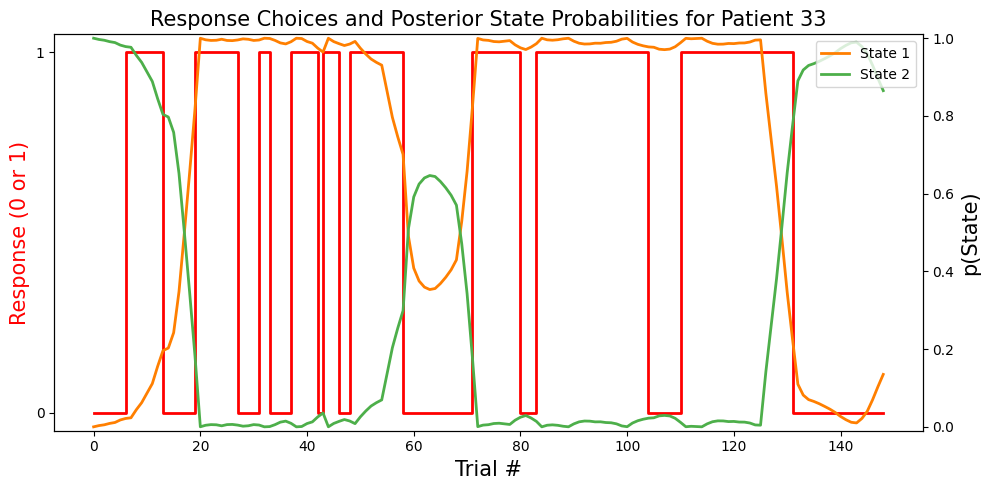

In [885]:
patients = [12, 13, 14, 19, 22, 25, 27, 28, 30, 31, 33]

# Define covariate columns and output column
covariate_columns = ['diff_pitch0', 'diff_pitch1', 'diff_pitch2', 'diff_pitch3', 
                     'diff_pitch4', 'diff_pitch5', 'diff_pitch6', 'choice_history']
output_column = 'response'

# Define colors for plotting states
cols = ['#ff7f00', '#4daf4a', '#377eb8']

# Iterate over each patient in the list
for subject_id in patients:
    print(f"Processing patient {subject_id}")
    
    # Filter data for the current patient
    subject_df = df_diff[df_diff['subject'] == subject_id]
    subject_df['choice_history'] = subject_df['response'].shift(1)
    subject_df = subject_df.dropna(subset=['choice_history'])
    
    # Prepare covariates and responses
    covariates = subject_df[covariate_columns].values
    bias_term = np.ones((covariates.shape[0], 1))  # Create a column of ones (bias term)
    covariates = np.hstack([bias_term, covariates])  # Concatenate bias term
    responses = subject_df[output_column].values.reshape(-1, 1)
    
    # Define and fit the GLM-HMM
    num_states = 2  # Number of discrete states
    obs_dim = 1  # Observed dimension (binary responses)
    num_categories = 2  # Number of categories for output (binary)
    input_dim = covariates.shape[1]  # Input dimension including bias term
    
    new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs",
                         observation_kwargs=dict(C=num_categories), transitions="standard")
    
    # Fit the model
    N_iters = 1000  # Maximum number of EM iterations
    fit_ll = new_glmhmm.fit(responses, inputs=covariates, method="em", num_iters=N_iters, tolerance=10**-4)
    
    # Retrieve weights for plotting
    recovered_weights = new_glmhmm.observations.params
    fig = plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

    # Plot recovered weights for each state
    for k in range(num_states):
        plt.plot(range(input_dim - 2), (recovered_weights[k][0])[:-2], color=cols[k],
                 lw=1.5, label=f"Patient {subject_id} - State {k + 1}: Recovered", linestyle='--')

    # Set plot labels and title
    plt.xlabel("Covariate Index", fontsize=12)
    plt.ylabel("Weight Value", fontsize=12)
    plt.title(f"GLM Weights for Patient {subject_id}", fontsize=14)
    plt.legend()
    plt.show()
    
    # Plot log probabilities during EM fitting
    plt.figure(figsize=(4, 3))
    plt.plot(fit_ll, label="EM")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.title(f"Log Probability for Patient {subject_id}")
    plt.legend()
    plt.show()
    
    # Plot posterior state probabilities
    posterior_probs = new_glmhmm.expected_states(data=responses, input=covariates)[0]
    plt.figure(figsize=(8, 4))
    for k in range(num_states):
        plt.plot(posterior_probs[:, k], label=f"State {k + 1}", lw=2, color=cols[k])
    plt.xlabel("Trial #")
    plt.ylabel("p(State)")
    plt.title(f"Posterior State Probabilities for Patient {subject_id}")
    plt.legend()
    plt.show()
    
    # Plot response choices and state probabilities
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.step(range(len(responses)), responses, color="red", lw=2)
    ax1.set_yticks([0, 1])
    ax1.set_xlabel("Trial #", fontsize=15)
    ax1.set_ylabel("Response (0 or 1)", fontsize=15, color="red")
    
    ax2 = ax1.twinx()
    for k in range(num_states):
        ax2.plot(range(len(responses)), posterior_probs[:, k], label=f"State {k + 1}", lw=2, color=cols[k])
    ax2.set_ylim((-0.01, 1.01))
    ax2.set_ylabel("p(State)", fontsize=15)
    
    # Combine the legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
    
    plt.title(f"Response Choices and Posterior State Probabilities for Patient {subject_id}", fontsize=15)
    plt.tight_layout()
    plt.show()

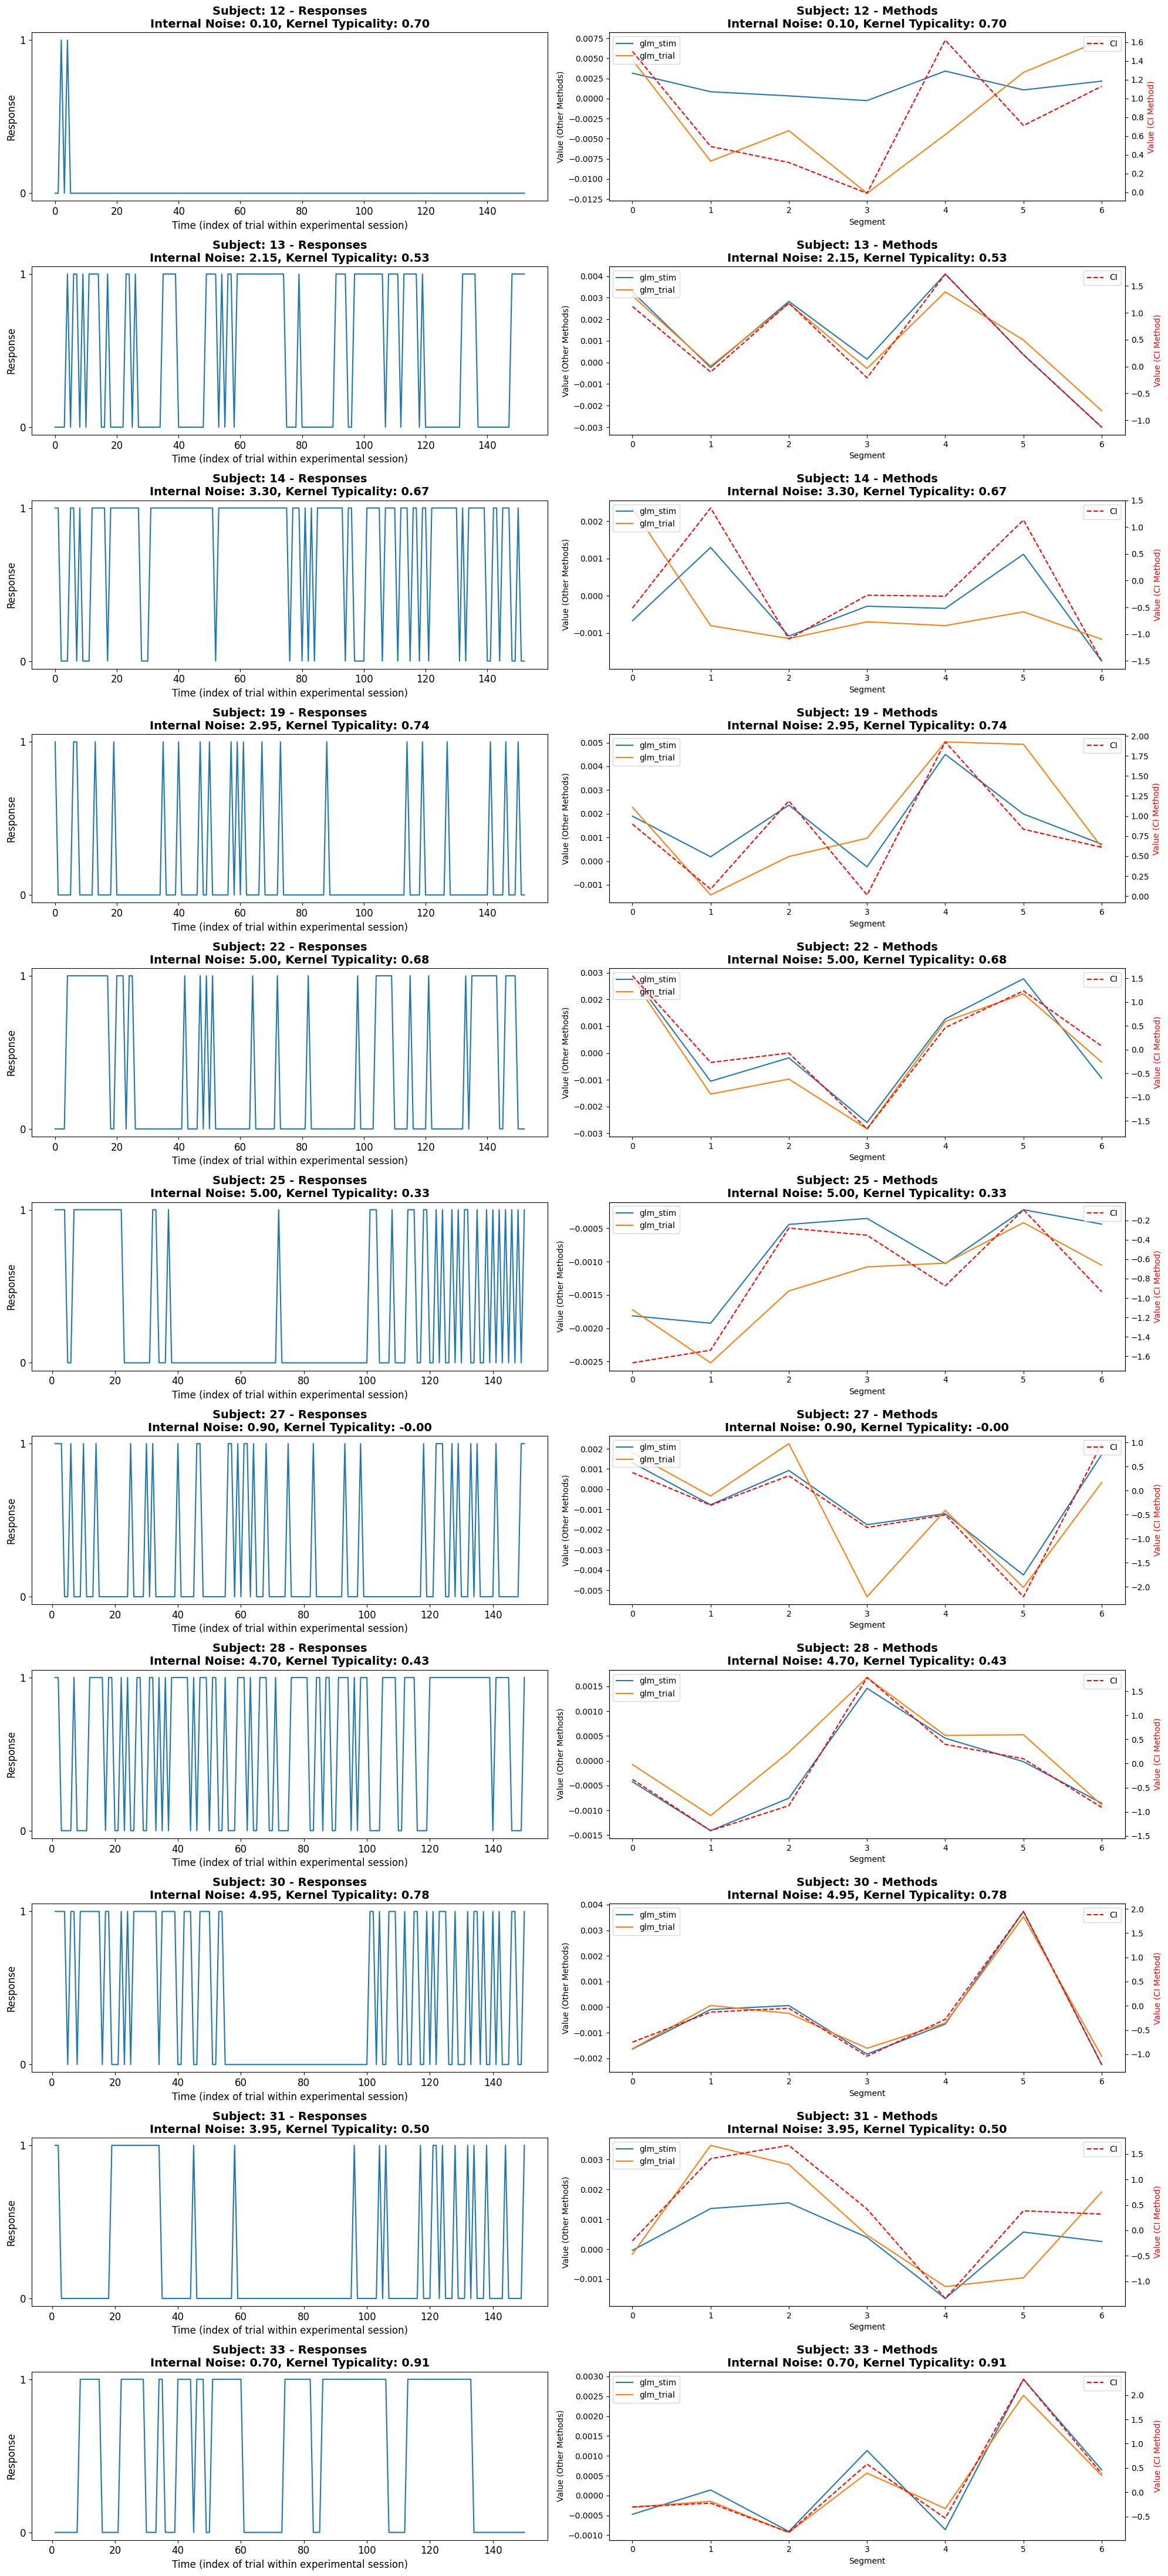

In [26]:
patients = [12, 13, 14, 19, 22, 25, 27, 28, 30, 31, 33]

# Get the patient sessions
patient_sessions = revcor[(revcor.type == "patients") & (revcor.subject.isin(patients)) & (revcor.session == 1)].groupby(["subject", "session"], as_index=False).trial.count()

num_rows = len(patient_sessions)

# Set up the figure to have two plots side by side for each subject
fig, axs = plt.subplots(num_rows, 2, figsize=(20, num_rows * 4))

for i, patient_session in enumerate(zip(patient_sessions.subject, patient_sessions.session)):
    patient = patient_session[0]
    session = patient_session[1]

    # Fetch the internal_noise_with_criteria and kernel_typicality values from revcor_measures dataframe for the patient
    noise_value = revcor_measures[revcor_measures['subject'] == patient]['internal_noise_with_criteria'].values[0]
    typicality_value = revcor_measures[revcor_measures['subject'] == patient]['kernel_typicality'].values[0]

    # Filter the data for the current patient and session for the response plot
    patient_responses = revcor[(revcor.subject == patient) & (revcor.session == session) & (revcor.stim_order == 0)].groupby('trial')['response'].first()

    # Plot the response for each session on the left subplot (axs[i, 0])
    axs[i, 0].plot(patient_responses)
    axs[i, 0].set_yticks([0, 1])
    axs[i, 0].set_ylabel('Response', fontsize=12)
    axs[i, 0].set_xlabel('Time (index of trial within experimental session)', fontsize=12)
    axs[i, 0].grid(False)
    axs[i, 0].set_facecolor('white')
    axs[i, 0].tick_params(axis='both', which='major', labelsize=12)
    axs[i, 0].set_title(f'Subject: {patient} - Responses\nInternal Noise: {noise_value:.2f}, Kernel Typicality: {typicality_value:.2f}', fontsize=14, fontweight='bold')

    # Filter data for the method plot
    subject_data = merged_df[merged_df['subject'] == patient]
    subject_type = subject_data['type'].iloc[0]  # Get the subject's type

    # Plot methods that are not 'CI' on the primary y-axis (right subplot: axs[i, 1])
    non_ci_methods = subject_data[subject_data['method'] != 'CI']
    for method in non_ci_methods['method'].unique():
        data = non_ci_methods[non_ci_methods['method'] == method]
        axs[i, 1].plot(data['segment'], data['value'], label=method)

    # Create a secondary y-axis for the 'CI' method
    ax2 = axs[i, 1].twinx()
    ci_data = subject_data[subject_data['method'] == 'CI']
    if not ci_data.empty:
        ax2.plot(ci_data['segment'], ci_data['value'], label='CI', linestyle='--', color='r')

    axs[i, 1].set_xlabel('Segment')
    axs[i, 1].set_ylabel('Value (Other Methods)')
    ax2.set_ylabel('Value (CI Method)', color='r')
    axs[i, 1].legend(loc='upper left')
    ax2.legend(loc='upper right')
    axs[i, 1].set_title(f'Subject: {patient} - Methods\nInternal Noise: {noise_value:.2f}, Kernel Typicality: {typicality_value:.2f}', fontsize=14, fontweight='bold')

# Adjust the layout to avoid overlap between subplots
plt.tight_layout()
plt.show()

In [205]:
subject_id = 31
subject_df = df_diff[df_diff['subject'] == subject_id]
subject_df['choice_history'] = subject_df['response'].shift(1)
subject_df = subject_df.dropna(subset=['choice_history'])
subject_df

subject  block  trial  session  diff_pitch0  diff_pitch1  diff_pitch2  \
6940       31      1      2        1    99.952203   -86.183656    63.850961   
6941       31      1      3        1  -117.619611    34.514892   -94.983577   
6942       31      1      4        1  -158.390604   -89.987419   -52.748433   
6943       31      1      5        1     2.416750  -163.310435  -145.785253   
6944       31      1      6        1   170.479686   -42.646958    23.035779   
...       ...    ...    ...      ...          ...          ...          ...   
7084       31      3    146        1    83.130101   -49.668521    -3.397537   
7085       31      3    147        1   -20.859480   -63.563264   166.389480   
7086       31      3    148        1  -119.696582  -163.319162   -49.898403   
7087       31      3    149        1   -32.969181   -94.094375   162.795552   
7088       31      3    150        1    65.205594   -13.734685   -60.110661   

      diff_pitch3  diff_pitch4  diff_pitch5  diff_pitch6      type  response  \
6940    92.722889    30.189691    76.095846    29.104119  patients         1   
6941   111.680698   193.642429    73.785643   103.323797  patients         0   
6942    38.545015    15.358231     9.205518   108.944783  patients         0   
6943   -64.089367  -103.667109   -68.323081   -67.399392  patients         0   
6944  -185.036172   -57.194952   139.514081   -77.601470  patients         0   
...           ...          ...          ...          ...       ...       ...   
7084  -143.922495    70.050083  -101.070899   -15.011281  patients         0   
7085   -64.580005  -224.812650   129.864273    12.408203  patients         0   
7086   192.917104   -80.787926    43.590910   -54.576800  patients         0   
7087   119.569434   -76.283539   -82.687338   -56.591783  patients         0   
7088  -270.179972   -56.712927    98.893280    55.673627  patients         1   

      choice_history  
6940             1.0  
6941             1.0  
6942             0.0  
6943             0.0  
6944             0.0  
...              ...  
7084             0.0  
7085             0.0  
7086             0.0  
7087             0.0  
7088             0.0  

[149 rows x 14 columns]

In [206]:
covariate_columns = ['diff_pitch0', 'diff_pitch1', 'diff_pitch2', 'diff_pitch3', 
                     'diff_pitch4', 'diff_pitch5', 'diff_pitch6','choice_history']

output_column = 'response'

covariates = subject_df[covariate_columns].values
#bias_term = np.ones((covariates.shape[0], 1))  # Create a column of ones

# Concatenate the bias term to the covariates
#covariates = np.hstack([bias_term, covariates])
responses = subject_df[output_column].values.reshape(-1, 1) 

In [207]:
print("Shape of responses:", responses.shape)
print("Shape of covariates:", covariates.shape)

Shape of responses: (149, 1)
Shape of covariates: (149, 8)


## 2. Input Driven Observations


In [208]:
glm = ssm.HMM(1, 1, 8, observations="input_driven_obs", 
                   observation_kwargs=dict(C=2), transitions="standard")
print(glm.observations.params)
print(glm.transitions.params)
ll_glm=glm.fit(responses, inputs=covariates, method="em", num_iters=100, tolerance=10**-3)

[[[ 1.84369153  1.52550724 -1.44553558  0.37716061 -0.07055723
    0.60415971  0.472149    0.81991729]]]
(array([[0.]]),)


  0%|          | 0/100 [00:00<?, ?it/s]

## 3. Fit GLM-HMM and perform recovery analysis

## 3a. Maximum Likelihood Estimation

In [209]:
npr.seed(0)
# Set the parameters of the GLM-HMM
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 8         # input dimensions

In [210]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
N_iters = 1000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(responses, inputs=covariates, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

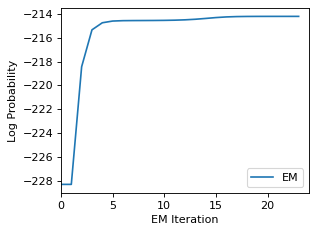

In [211]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
#plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### 3b. Retrieved parameters

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (9).

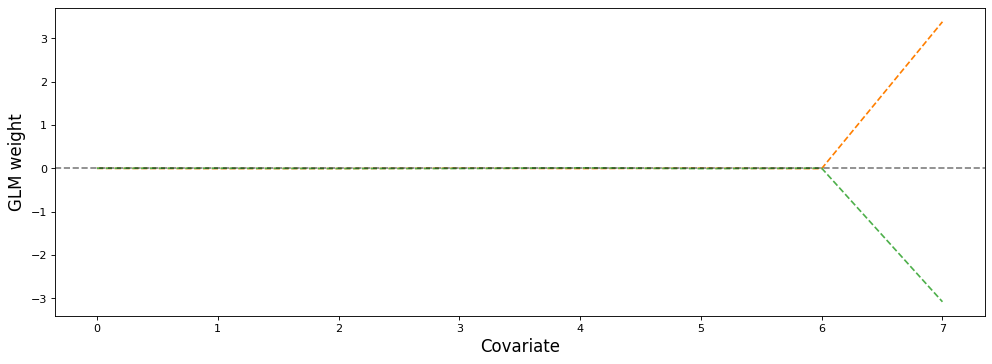

In [212]:
import matplotlib.pyplot as plt

# Set figure size and DPI for clarity
fig = plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Define colors for each state
cols = ['#ff7f00', '#4daf4a', '#377eb8','#984ea3']  # Orange, Green, Blue for states

# Retrieve recovered weights from the GLM-HMM model
recovered_weights = new_glmhmm.observations.params

# Loop through the number of states and plot both generative and recovered weights
for k in range(num_states):
    # Plot the recovered weights for each state
    plt.plot(range(input_dim), (recovered_weights[k][0])[:], color=cols[k],
             lw=1.5, label=f"State {k+1}: recovered", linestyle='--')

# Set y-axis ticks font size
plt.yticks(fontsize=10)

# Add labels for the axes
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariate", fontsize=15)

# Add horizontal line at y=0 to visualize where the weights cross zero
plt.axhline(y=0, color="k", alpha=0.5, ls="--")

# Add labels for covariates, modify according to the number of covariates in your data
plt.xticks(range(input_dim), ['pitch0', 'pitch1', 'pitch2', 'pitch3', 'pitch4', 'pitch5', 'pitch6','rh','bias'], 
           fontsize=12, rotation=45)

# Add a legend to differentiate between generative and recovered weights for each state
plt.legend()

# Set the title for the plot
plt.title("Comparison of Generative and Recovered Weights for GLM-HMM States", fontsize=15)

# Display the plot
plt.show()


Text(0.5, 1.0, 'recovered')

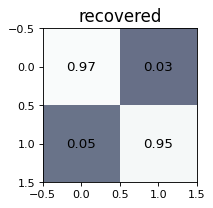

In [213]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')

recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
#plt.xticks(range(0, num_states), ('1', '2','3'), fontsize=10)
#plt.yticks(range(0, num_states), ('1', '2','3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)


Text(0, 0.5, 'observation class')

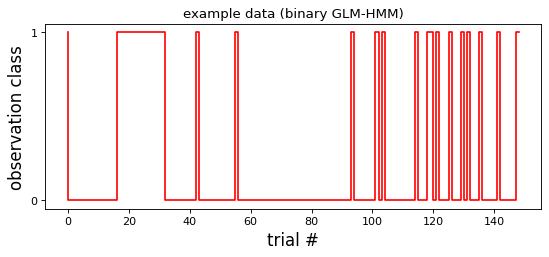

In [214]:
# plot example data:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.step(range(149),responses[range(149)], color = "red")
plt.yticks([0, 1])
plt.title("example data (binary GLM-HMM)")
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("observation class", fontsize = 15)

### 3c. Posterior State Probabilities

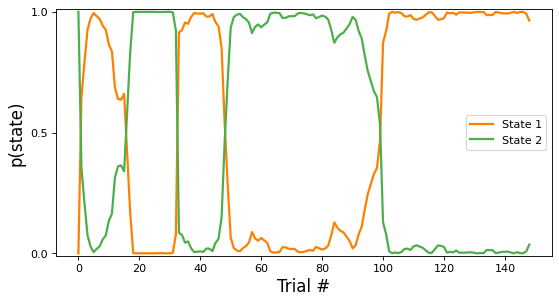

In [215]:
fig = plt.figure(figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
posterior_probs = new_glmhmm.expected_states(data=responses, input=covariates)[0]

# Iterate through states and plot posterior probabilities
num_states = posterior_probs.shape[1]  # Assuming posterior_probs is (n_trials, num_states)

for k in range(num_states):
    plt.plot(posterior_probs[:, k], label="State " + str(k + 1), lw=2, color=cols[k])

# Set plot limits and labels
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize=10)
plt.xlabel("Trial #", fontsize=15)
plt.ylabel("p(state)", fontsize=15)

# Add legend to distinguish between states
plt.legend()

# Show plot
plt.show()

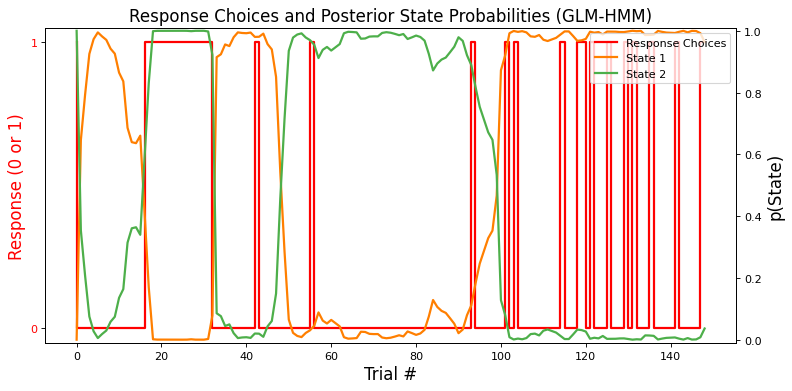

In [216]:
cols = ['#ff7f00', '#4daf4a', '#377eb8','#984ea3']

# Create a figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

# Plot the response choices (0 or 1) on the first y-axis (ax1)
ax1.step(range(len(responses)), responses, color="red", label="Response Choices", lw=2)
ax1.set_yticks([0, 1])
ax1.set_title("Response Choices and Posterior State Probabilities (GLM-HMM)", fontsize=15)
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("Response (0 or 1)", fontsize=15, color="red")
ax1.tick_params(axis='y', labelcolor="red")

# Create a second y-axis (ax2) to plot the posterior state probabilities
ax2 = ax1.twinx()
for k in range(num_states):
    ax2.plot(range(len(responses)), posterior_probs[:, k], label="State " + str(k + 1), lw=2, color=cols[k])

# Adjust limits and labels for the second axis
ax2.set_ylim((-0.01, 1.01))
ax2.set_ylabel("p(State)", fontsize=15)
ax2.tick_params(axis='y')

# Add combined legend for response choices and state probabilities
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()

In [217]:
inferred_states = new_glmhmm.most_likely_states(responses, input=covariates)
inferred_states

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [218]:
weights

array([[[ 2.04150170e-03,  9.13331729e-04, -6.23024105e-04,
          6.26437770e-04,  3.27812905e-03,  7.43836923e-04,
         -1.65125332e-04, -1.60954659e+00]],

       [[-1.14476490e-02, -4.04567202e-03,  7.10692820e-03,
          2.76558766e-03, -4.68495063e-03, -4.01625957e-03,
          7.32641786e-04, -3.47221952e+00]]])

In [219]:
weights[1][0]

array([-1.14476490e-02, -4.04567202e-03,  7.10692820e-03,  2.76558766e-03,
       -4.68495063e-03, -4.01625957e-03,  7.32641786e-04, -3.47221952e+00])

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (9).

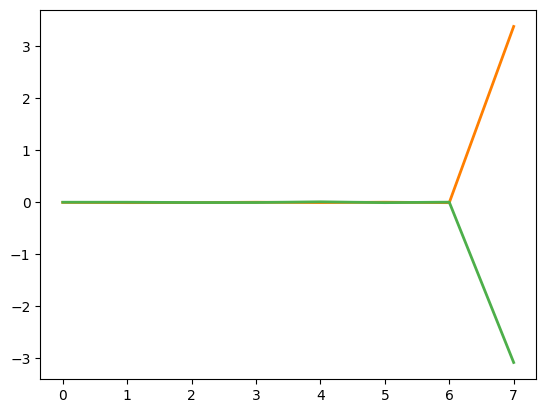

In [221]:
weights = new_glmhmm.observations.params  # This contains GLM weights for each state

# Automatically exclude the last value from each state's GLM weights
weights_excluded_last = [weight[:,:] for weight in weights]

# Plot the weights for each state with the specified colors
for state, weight in enumerate(weights_excluded_last):
    plt.plot(weight[0], label=f'State {state + 1}', color=cols[state], lw=2)  # Plot without the last value
plt.xticks(range(input_dim), ['pitch0', 'pitch1', 'pitch2', 'pitch3', 'pitch4', 'pitch5', 'pitch6','rh','bias'], 
           fontsize=12, rotation=45)
# Add labels and title to the plot
plt.xlabel('External inputs', fontsize=12)
plt.ylabel('GLM Weight', fontsize=12)
plt.title('GLM Weights by State ', fontsize=14)
plt.legend()
plt.show()

In [41]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

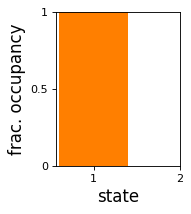

In [1086]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1], ['1', '2'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

## Residuals

In [686]:
def sigmoid(x):
    """ Sigmoid function for converting GLM linear prediction into probability """
    return 1 / (1 + np.exp(-x))

def get_predicted_responses(glmhmm, covariates, posterior_probs):
    """ Get predicted responses based on GLM-HMM fitting """
    predicted_responses = []
    weights = glmhmm.observations.params
    
    # Get the state with the highest posterior probability for each trial
    max_posterior_states = np.argmax(posterior_probs, axis=1)
    
    for i, state in enumerate(max_posterior_states):
        # Linear prediction using GLM weights
        linear_pred = np.dot(covariates[i], weights[state][0])
        
        # Convert to predicted probability (logistic regression)
        predicted_prob = sigmoid(linear_pred)
        
        # Convert probability to binary response (0 or 1)
        predicted_responses.append(predicted_prob)
    
    return np.array(predicted_responses)

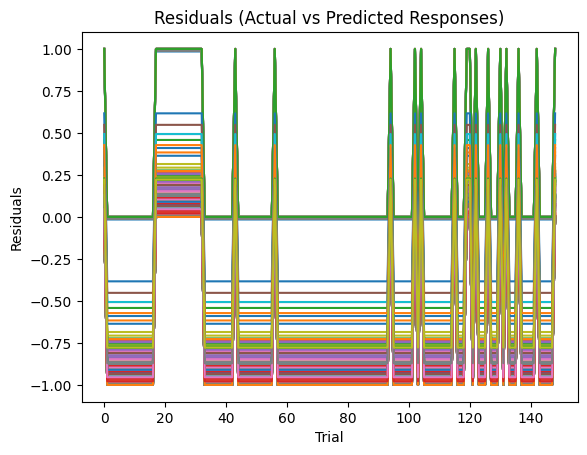

In [687]:
def calculate_residuals(actual_responses, predicted_responses):
    """ Calculate residuals (difference between actual and predicted responses) """
    residuals = actual_responses - predicted_responses
    return residuals

# Example: Get residuals for one block of trials
predicted_responses = get_predicted_responses(new_glmhmm, covariates, posterior_probs)
residuals = calculate_residuals(responses, predicted_responses)

# Plot the residuals
plt.plot(residuals)
plt.xlabel('Trial')
plt.ylabel('Residuals')
plt.title('Residuals (Actual vs Predicted Responses)')
plt.show()

In [688]:
noise_std = np.std(residuals)
print(f"Estimated noise (standard deviation of residuals): {noise_std}")


Estimated noise (standard deviation of residuals): 0.5141203216390459


##  Cross Validation ML

To assess which model is better - the model fit via Maximum Likelihood Estimation and how many number of states or inputs or iterations we can investigate the predictive power of these fit models on held-out test data sets.

Fitting for 1 states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Average log-likelihood for 1 states: -91.96399506069069
Fitting for 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Average log-likelihood for 2 states: -163.97034688950006
Fitting for 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Average log-likelihood for 3 states: -293.42387756636737
Fitting for 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Average log-likelihood for 4 states: -406.63255756119844
Fitting for 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Average log-likelihood for 5 states: -439.205963264107


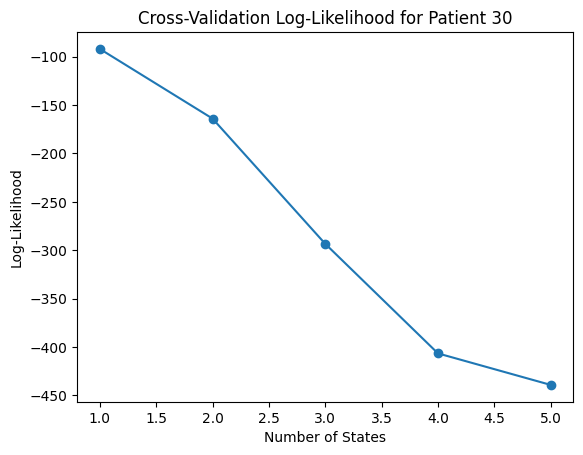

In [1070]:
from sklearn.model_selection import KFold

subject_id = 30
subject_df = df_diff[df_diff['subject'] == subject_id]
subject_df['choice_history'] = subject_df['response'].shift(1)
subject_df = subject_df.dropna(subset=['choice_history'])

# Define covariate columns and output column
covariate_columns = ['diff_pitch0', 'diff_pitch1', 'diff_pitch2', 'diff_pitch3', 
                     'diff_pitch4', 'diff_pitch5', 'diff_pitch6', 'choice_history']
output_column = 'response'

# Prepare covariates and responses
covariates = subject_df[covariate_columns].values
bias_term = np.ones((covariates.shape[0], 1))  # Add a bias term
covariates = np.hstack([bias_term, covariates])  # Concatenate the bias term
responses = subject_df[output_column].values.reshape(-1, 1)

# Define parameters for cross-validation
max_states = 5  # Test up to 5 states
kf = KFold(n_splits=5)  # 5-fold cross-validation

# Store log-likelihoods for different numbers of states
log_likelihoods = []

# Loop through different numbers of states
for num_states in range(1, max_states + 1):
    fold_lls = []  # Store log-likelihood for each fold
    print(f"Fitting for {num_states} states")
    
    for train_index, test_index in kf.split(covariates):
        # Split into training and test sets for cross-validation
        covariates_train, covariates_test = covariates[train_index], covariates[test_index]
        responses_train, responses_test = responses[train_index], responses[test_index]

        # Define GLM-HMM model for the current number of states
        obs_dim = 1  # Binary responses
        input_dim = covariates_train.shape[1]  # Including bias term
        num_categories = 2  # Binary output

        glm_hmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs",
                          observation_kwargs=dict(C=num_categories), transitions="standard")

        # Fit the model
        glm_hmm.fit(responses_train, inputs=covariates_train, method="em", num_iters=1000, tolerance=10**-4)
        
        # Calculate log-likelihood on the test set
        fold_ll = glm_hmm.log_probability(responses_test, inputs=covariates_test)
        fold_lls.append(fold_ll)
    
    # Average log-likelihood over the cross-validation folds
    avg_ll = np.mean(fold_lls)
    log_likelihoods.append(avg_ll)
    print(f"Average log-likelihood for {num_states} states: {avg_ll}")

# Plot the log-likelihood for different numbers of states
plt.plot(range(1, max_states + 1), log_likelihoods, marker='o')
plt.xlabel('Number of States')
plt.ylabel('Log-Likelihood')
plt.title(f'Cross-Validation Log-Likelihood for Patient {subject_id}')
plt.show()

In [ ]:
# Create additional input sequences to be used as held-out test data
num_test_sess = 10
test_inpts = np.ones((num_test_sess, num_trials_per_sess, input_dim)) 
test_inpts[:,:,0] = np.random.choice(stim_vals, (num_test_sess, num_trials_per_sess)) 
test_inpts = list(test_inpts)

In [ ]:
# Create set of test latents and choices to accompany input sequences:
test_latents, test_choices = [], []
for sess in range(num_test_sess):
    test_z, test_y = true_glmhmm.sample(num_trials_per_sess, input=test_inpts[sess])
    test_latents.append(test_z)
    test_choices.append(test_y)

In [ ]:
# Compare likelihood of test_choices for model fit with MLE with varied parameters:
mle_test_ll = new_glmhmm.log_likelihood(test_choices, inputs=test_inpts) 

Text(0, 0.5, 'loglikelihood')

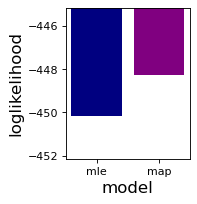

In [ ]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_test_ll, map_test_ll]
colors = ['Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((mle_test_ll-2, mle_test_ll+5))
plt.xticks([0], ['mle'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

## 4. Fit GLM-HMM and perform recovery analysis: Maximum A Priori Estimation

Above, we performed Maximum Likelihood Estimation to retrieve the generative parameters of the GLM-HMM in simulated data. In the small data regime, where we do not have many trials available to us, we may instead want to perform Maximum A Priori (MAP) Estimation in order to incorporate a prior term and restrict the range for the best fitting parameters. Unfortunately, what is meant by 'small data regime' is problem dependent and will be affected by the number of states in the generative GLM-HMM, and the specific parameters of the generative model, amongst other things. In practice, we may perform both Maximum Likelihood Estimation and MAP estimation and compare the ability of the fit models to make predictions on held-out data (see Section 5 on Cross-Validation below).  

The prior we consider for the GLM-HMM is the product of a Gaussian prior on the GLM weights, $W$, and a Dirichlet prior on the transition matrix, $A$:

$$
\begin{align}
\Pr(W, A) &= \mathcal{N}(W|0, \Sigma) \Pr(A|\alpha) \\&= \mathcal{N}(W|0, diag(\sigma^{2}, \cdots, \sigma^{2})) \prod_{j=1}^{K} \dfrac{1}{B(\alpha)} \prod_{k=1}^{K} A_{jk}^{\alpha -1}
\end{align}
$$

There are two hyperparameters controlling the strength of the prior: $\sigma$ and $\alpha$.  The larger the value of $\sigma$ and if $\alpha = 1$, the more similar MAP estimation will become to Maximum Likelihood Estimation, and the prior term will become an additive offset to the objective function of the GLM-HMM that is independent of the values of $W$ and $A$.  In comparison, setting $\sigma = 2$ and $\alpha = 2$ will result in the prior no longer being independent of $W$ and $\alpha$.  

In order to perform MAP estimation for the GLM-HMM with `ssm`, the new syntax is:

```python
ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
```

where `prior_sigma` is the $\sigma$ parameter from above, and `prior_alpha` is the $\alpha$ parameter.

In [28]:
# Instantiate GLM-HMM and set prior hyperparameters
prior_sigma = 2
prior_alpha = 2
map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

In [29]:
# Fit GLM-HMM with MAP estimation:
_ = map_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/25 [00:00<?, ?it/s]

Compare final likelihood of data with MAP estimation and MLE to likelihood under generative model (note: we cannot use log_probability that is output of `fit` function as this incorporates prior term, which is not comparable between generative and MAP models). We want to check that MAP and MLE likelihood values are higher than true likelihood; if they are not, this may indicate a poor initialization and that we should refit these models.

In [30]:
true_likelihood = true_glmhmm.log_likelihood(true_choices, inputs=inpts)
mle_final_ll = new_glmhmm.log_likelihood(true_choices, inputs=inpts) 
map_final_ll = map_glmhmm.log_likelihood(true_choices, inputs=inpts) 

Text(0, 0.5, 'loglikelihood')

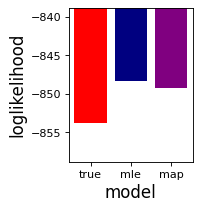

In [31]:
# Plot these values
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [true_likelihood, mle_final_ll, map_final_ll]
colors = ['Red', 'Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((true_likelihood-5, true_likelihood+15))
plt.xticks([0, 1, 2], ['true', 'mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

## 5. Cross Validation

To assess which model is better - the model fit via Maximum Likelihood Estimation, or the model fit via MAP estimation - we can investigate the predictive power of these fit models on held-out test data sets.

In [32]:
# Create additional input sequences to be used as held-out test data
num_test_sess = 10
test_inpts = np.ones((num_test_sess, num_trials_per_sess, input_dim)) 
test_inpts[:,:,0] = np.random.choice(stim_vals, (num_test_sess, num_trials_per_sess)) 
test_inpts = list(test_inpts)

In [33]:
# Create set of test latents and choices to accompany input sequences:
test_latents, test_choices = [], []
for sess in range(num_test_sess):
    test_z, test_y = true_glmhmm.sample(num_trials_per_sess, input=test_inpts[sess])
    test_latents.append(test_z)
    test_choices.append(test_y)

In [34]:
# Compare likelihood of test_choices for model fit with MLE and MAP:
mle_test_ll = new_glmhmm.log_likelihood(test_choices, inputs=test_inpts) 
map_test_ll = map_glmhmm.log_likelihood(test_choices, inputs=test_inpts) 

Text(0, 0.5, 'loglikelihood')

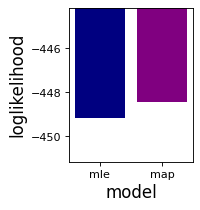

In [35]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_test_ll, map_test_ll]
colors = ['Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((mle_test_ll-2, mle_test_ll+5))
plt.xticks([0, 1], ['mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

Here we see that the model fit with MAP estimation achieves higher likelihood on the held-out dataset than the model fit with MLE, so we would choose this model as the best model of animal decision-making behavior (although we'd probably want to perform multiple fold cross-validation to be sure that this is the case in all instantiations of test data).   

Let's finish by comparing the retrieved weights and transition matrices from MAP estimation to the generative parameters.

In [36]:
map_glmhmm.permute(find_permutation(true_latents[0], map_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

Text(0.5, 1.0, 'MAP')

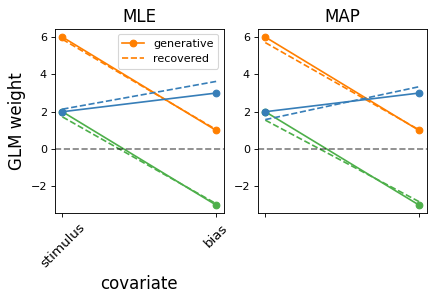

In [37]:
fig = plt.figure(figsize=(6, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
plt.subplot(1,2,1)
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0: # show labels only for first state
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k],
                 lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = 'recovered', linestyle='--')   
    else:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], 
                 lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle='--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("MLE", fontsize = 15)
plt.legend()

plt.subplot(1,2,2)
recovered_weights = map_glmhmm.observations.params
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k],
             lw=1.5, label="", linestyle = '-')
    plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                 lw=1.5,  label = '', linestyle='--')
plt.yticks(fontsize=10)
plt.xticks([0, 1], ['', ''], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("MAP", fontsize = 15)

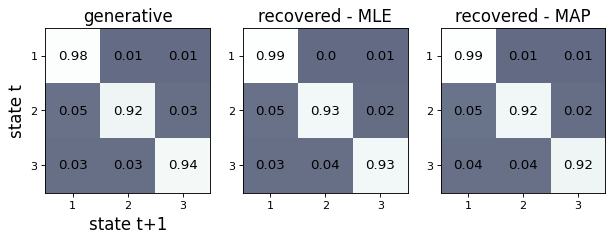

In [38]:
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("generative", fontsize = 15)


plt.subplot(1, 3, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered - MLE", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


plt.subplot(1, 3, 3)
recovered_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered - MAP", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)